<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/mlp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install scikit-optimize

In [11]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [12]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize, dump, load
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import pdb  # Brug det

In [13]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [14]:
# ------------------- Read and prep data ------------------------------------ #

train_data = np.load(DATA_DIR.joinpath('train.npy'))
test_data = np.load(DATA_DIR.joinpath('test.npy'))

x_train = train_data[:, 1:]
y_train = train_data[:, 0]

input_dims=x_train.shape[-1]

x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# There is no reason to scale y_test actually
y_test = scaler_y.transform(y_test.reshape(-1, 1))


x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        """Initialize with X and y."""
        self.features = features
        self.targets = targets

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, index):
        """Generate one data sample."""
        return self.features[index], self.targets[index]

In [15]:
# ------------------- NN setup ---------------------------------------------- #

class NeuralNet(nn.Module):
    """Neural Network class."""

    def __init__(self, input_dims=input_dims, n_layers=3, n_neurons=64,
                 activation=nn.ELU(), dropout_rate=0.5):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super(NeuralNet, self).__init__()

        self.input_dims = input_dims
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Layer structure
        # First layer
        self.in_layer = nn.Linear(self.input_dims, self.n_neurons)

        # Dense, Dropout, Activation and BN
        self.dense = nn.Linear(self.n_neurons, self.n_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = activation
        self.batchnorm = nn.BatchNorm1d(self.n_neurons)

        # Output layer
        self.out_layer = nn.Linear(self.n_neurons, 1)

    def forward(self, x):
        """Forward pass."""
                
        x = self.batchnorm(self.activation(self.dropout(self.in_layer(x))))

        for i in range(self.n_layers-1):
            x = self.batchnorm(self.activation(self.dropout(self.dense(x))))

        x = self.out_layer(x)

        return x


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn,
                  n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    best_model = copy.deepcopy(model.state_dict())
    
    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets,
                                           optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Stopping after {epoch} epochs due to no improvement.')
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ', end='')
                print(f'Val Loss: {val_epoch_loss:.4}')

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [18]:
# ------------------- Cross-validation -------------------------------------- #

def kfold_cv_train(x_train, y_train, model, optimizer,loss_fn=nn.MSELoss(), 
                   n_splits=5, batch_size=312, n_epochs=2000, patience=100,
                   shuffle=True, rng=SEED):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        # print(f'Starting fold {fold + 1}')
        # Get training and val features
        x_train_fold = x_train[train_index]
        x_val_fold = x_train[val_index]

        # Get training and val targets
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        train = Dataset(x_train_fold, y_train_fold)
        train_loader = DataLoader(train, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=True)
        # Create val dataset and dataloader
        val = Dataset(x_val_fold, y_val_fold)
        val_loader = DataLoader(val, batch_size=batch_size,
                                shuffle=False, drop_last=False)

        # Train
        train_loss, val_loss = train_network(model=model,
                                             train_data=train_loader,
                                             val_data=val_loader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             n_epochs=n_epochs,
                                             patience=patience,
                                             print_progress=False)
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses)/n_splits, train_loss, val_loss




Gaussian Process:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
Stopping after 213 epochs due to no improvement.
Stopping after 618 epochs due to no improvement.
Stopping after 538 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.





Gaussian Process:   0%|          | 1/500 [00:24<3:27:31, 24.95s/it]

Stopping after 363 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 24.9472
Function value obtained: 0.0167
Current minimum: 0.0167
Iteration No: 2 started. Evaluating function at random point.
Stopping after 477 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 328 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.





Gaussian Process:   0%|          | 2/500 [00:51<3:31:16, 25.46s/it]

Stopping after 229 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 26.6284
Function value obtained: 0.0154
Current minimum: 0.0154
Iteration No: 3 started. Evaluating function at random point.
Stopping after 156 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 503 epochs due to no improvement.





Gaussian Process:   1%|          | 3/500 [01:16<3:28:43, 25.20s/it]

Stopping after 288 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 24.6015
Function value obtained: 0.0171
Current minimum: 0.0154
Iteration No: 4 started. Evaluating function at random point.
Stopping after 224 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 525 epochs due to no improvement.





Gaussian Process:   1%|          | 4/500 [01:44<3:37:02, 26.25s/it]

Stopping after 271 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 28.7158
Function value obtained: 0.0177
Current minimum: 0.0154
Iteration No: 5 started. Evaluating function at random point.
Stopping after 236 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 575 epochs due to no improvement.





Gaussian Process:   1%|          | 5/500 [02:11<3:36:43, 26.27s/it]

Stopping after 375 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 26.3013
Function value obtained: 0.0178
Current minimum: 0.0154
Iteration No: 6 started. Evaluating function at random point.
Stopping after 263 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.





Gaussian Process:   1%|          | 6/500 [02:28<3:14:10, 23.58s/it]

Stopping after 304 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.3220
Function value obtained: 0.0187
Current minimum: 0.0154
Iteration No: 7 started. Evaluating function at random point.
Stopping after 186 epochs due to no improvement.
Stopping after 446 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.





Gaussian Process:   1%|▏         | 7/500 [02:47<3:01:50, 22.13s/it]

Stopping after 247 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 18.7408
Function value obtained: 0.0170
Current minimum: 0.0154
Iteration No: 8 started. Evaluating function at random point.
Stopping after 268 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.





Gaussian Process:   2%|▏         | 8/500 [03:06<2:54:21, 21.26s/it]

Stopping after 207 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 19.2360
Function value obtained: 0.0172
Current minimum: 0.0154
Iteration No: 9 started. Evaluating function at random point.
Stopping after 160 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.





Gaussian Process:   2%|▏         | 9/500 [03:26<2:49:47, 20.75s/it]

Stopping after 208 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 19.5472
Function value obtained: 0.0159
Current minimum: 0.0154
Iteration No: 10 started. Evaluating function at random point.
Stopping after 101 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 523 epochs due to no improvement.





Gaussian Process:   2%|▏         | 10/500 [03:53<3:06:03, 22.78s/it]

Stopping after 399 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 27.5279
Function value obtained: 0.0215
Current minimum: 0.0154
Iteration No: 11 started. Evaluating function at random point.
Stopping after 317 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 296 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.





Gaussian Process:   2%|▏         | 11/500 [04:16<3:06:03, 22.83s/it]

Stopping after 334 epochs due to no improvement.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 22.9357
Function value obtained: 0.0159
Current minimum: 0.0154
Iteration No: 12 started. Evaluating function at random point.
Stopping after 144 epochs due to no improvement.
Stopping after 501 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 675 epochs due to no improvement.





Gaussian Process:   2%|▏         | 12/500 [04:43<3:16:42, 24.19s/it]

Stopping after 491 epochs due to no improvement.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 27.3545
Function value obtained: 0.0154
Current minimum: 0.0154
Iteration No: 13 started. Evaluating function at random point.
Stopping after 375 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.





Gaussian Process:   3%|▎         | 13/500 [05:12<3:27:01, 25.51s/it]

Stopping after 313 epochs due to no improvement.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 28.5846
Function value obtained: 0.0181
Current minimum: 0.0154
Iteration No: 14 started. Evaluating function at random point.
Stopping after 186 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.





Gaussian Process:   3%|▎         | 14/500 [05:29<3:05:43, 22.93s/it]

Stopping after 361 epochs due to no improvement.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 16.9173
Function value obtained: 0.0218
Current minimum: 0.0154
Iteration No: 15 started. Evaluating function at random point.
Stopping after 163 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.





Gaussian Process:   3%|▎         | 15/500 [05:50<3:01:45, 22.49s/it]

Stopping after 204 epochs due to no improvement.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 21.4482
Function value obtained: 0.0183
Current minimum: 0.0154
Iteration No: 16 started. Evaluating function at random point.
Stopping after 235 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.





Gaussian Process:   3%|▎         | 16/500 [06:07<2:47:47, 20.80s/it]

Stopping after 228 epochs due to no improvement.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 16.8686
Function value obtained: 0.0185
Current minimum: 0.0154
Iteration No: 17 started. Evaluating function at random point.
Stopping after 234 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.





Gaussian Process:   3%|▎         | 17/500 [06:30<2:53:30, 21.55s/it]

Stopping after 362 epochs due to no improvement.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 23.3088
Function value obtained: 0.0173
Current minimum: 0.0154
Iteration No: 18 started. Evaluating function at random point.
Stopping after 194 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.
Stopping after 483 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.





Gaussian Process:   4%|▎         | 18/500 [06:57<3:04:11, 22.93s/it]

Stopping after 205 epochs due to no improvement.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 26.1384
Function value obtained: 0.0174
Current minimum: 0.0154
Iteration No: 19 started. Evaluating function at random point.
Stopping after 118 epochs due to no improvement.
Stopping after 428 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.





Gaussian Process:   4%|▍         | 19/500 [07:14<2:51:34, 21.40s/it]

Stopping after 280 epochs due to no improvement.
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 17.8390
Function value obtained: 0.0236
Current minimum: 0.0154
Iteration No: 20 started. Evaluating function at random point.
Stopping after 268 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.





Gaussian Process:   4%|▍         | 20/500 [07:41<3:02:39, 22.83s/it]

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 26.1665
Function value obtained: 0.0157
Current minimum: 0.0154
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 148 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.





Gaussian Process:   4%|▍         | 21/500 [07:55<2:42:18, 20.33s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 14.4949
Function value obtained: 0.0157
Current minimum: 0.0154
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.





Gaussian Process:   4%|▍         | 22/500 [08:02<2:10:40, 16.40s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.2388
Function value obtained: 0.1585
Current minimum: 0.0154
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 135 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:   5%|▍         | 23/500 [08:10<1:49:41, 13.80s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.7119
Function value obtained: 0.0846
Current minimum: 0.0154
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:   5%|▍         | 24/500 [08:21<1:43:00, 12.98s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.0904
Function value obtained: 0.1407
Current minimum: 0.0154
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 185 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.





Gaussian Process:   5%|▌         | 25/500 [08:33<1:39:43, 12.60s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.6890
Function value obtained: 0.0242
Current minimum: 0.0154
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 237 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.





Gaussian Process:   5%|▌         | 26/500 [08:50<1:49:16, 13.83s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 16.7152
Function value obtained: 0.0152
Current minimum: 0.0152
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 227 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 472 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 658 epochs due to no improvement.





Gaussian Process:   5%|▌         | 27/500 [09:17<2:21:26, 17.94s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 27.5312
Function value obtained: 0.0158
Current minimum: 0.0152
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 262 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.





Gaussian Process:   6%|▌         | 28/500 [09:39<2:30:07, 19.08s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 21.7508
Function value obtained: 0.0212
Current minimum: 0.0152
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 404 epochs due to no improvement.
Stopping after 1058 epochs due to no improvement.
Stopping after 1172 epochs due to no improvement.
Stopping after 1570 epochs due to no improvement.
Stopping after 559 epochs due to no improvement.





Gaussian Process:   6%|▌         | 29/500 [10:41<4:10:41, 31.94s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 61.9212
Function value obtained: 0.0160
Current minimum: 0.0152
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 219 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.





Gaussian Process:   6%|▌         | 30/500 [10:52<3:20:42, 25.62s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 10.8852
Function value obtained: 0.1831
Current minimum: 0.0152
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 265 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.





Gaussian Process:   6%|▌         | 31/500 [11:06<2:53:32, 22.20s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 14.2273
Function value obtained: 0.0225
Current minimum: 0.0152
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.





Gaussian Process:   6%|▋         | 32/500 [11:29<2:54:40, 22.39s/it]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 22.8315
Function value obtained: 0.0188
Current minimum: 0.0152
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 184 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.





Gaussian Process:   7%|▋         | 33/500 [11:46<2:41:12, 20.71s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 16.7919
Function value obtained: 0.0194
Current minimum: 0.0152
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 141 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.





Gaussian Process:   7%|▋         | 34/500 [12:04<2:36:07, 20.10s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 18.6749
Function value obtained: 0.0150
Current minimum: 0.0150
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.





Gaussian Process:   7%|▋         | 35/500 [12:23<2:33:34, 19.82s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 19.1491
Function value obtained: 0.0182
Current minimum: 0.0150
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.





Gaussian Process:   7%|▋         | 36/500 [12:36<2:17:31, 17.78s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 13.0375
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 219 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.
Stopping after 1155 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.





Gaussian Process:   7%|▋         | 37/500 [13:07<2:46:48, 21.62s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 30.5636
Function value obtained: 0.0169
Current minimum: 0.0150
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 378 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 503 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.





Gaussian Process:   8%|▊         | 38/500 [13:29<2:46:31, 21.63s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 21.6452
Function value obtained: 0.0149
Current minimum: 0.0149
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 329 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.





Gaussian Process:   8%|▊         | 39/500 [13:46<2:36:22, 20.35s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 17.3767
Function value obtained: 0.0200
Current minimum: 0.0149
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 248 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.





Gaussian Process:   8%|▊         | 40/500 [14:05<2:33:09, 19.98s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 19.1045
Function value obtained: 0.0187
Current minimum: 0.0149
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 155 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 607 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.





Gaussian Process:   8%|▊         | 41/500 [14:29<2:42:39, 21.26s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 24.2573
Function value obtained: 0.0157
Current minimum: 0.0149
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 161 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.





Gaussian Process:   8%|▊         | 42/500 [14:47<2:33:10, 20.07s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 17.2765
Function value obtained: 0.0190
Current minimum: 0.0149
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 248 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:   9%|▊         | 43/500 [15:01<2:19:53, 18.37s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 14.4059
Function value obtained: 0.0233
Current minimum: 0.0149
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 249 epochs due to no improvement.
Stopping after 846 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 759 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.





Gaussian Process:   9%|▉         | 44/500 [15:33<2:50:22, 22.42s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 31.8620
Function value obtained: 0.0152
Current minimum: 0.0149
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 201 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.





Gaussian Process:   9%|▉         | 45/500 [15:54<2:46:33, 21.96s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 20.9037
Function value obtained: 0.0200
Current minimum: 0.0149
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 129 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.





Gaussian Process:   9%|▉         | 46/500 [16:11<2:36:05, 20.63s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 17.5109
Function value obtained: 0.0236
Current minimum: 0.0149
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 344 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.





Gaussian Process:   9%|▉         | 47/500 [16:37<2:46:53, 22.11s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 25.5585
Function value obtained: 0.0183
Current minimum: 0.0149
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 217 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.





Gaussian Process:  10%|▉         | 48/500 [16:54<2:34:17, 20.48s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 16.6858
Function value obtained: 0.0150
Current minimum: 0.0149
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 283 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 472 epochs due to no improvement.





Gaussian Process:  10%|▉         | 49/500 [17:14<2:33:49, 20.46s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 20.4228
Function value obtained: 0.0149
Current minimum: 0.0149
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 208 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.





Gaussian Process:  10%|█         | 50/500 [17:33<2:30:18, 20.04s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 19.0579
Function value obtained: 0.0151
Current minimum: 0.0149
Iteration No: 51 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.





Gaussian Process:  10%|█         | 51/500 [17:49<2:20:13, 18.74s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 15.6928
Function value obtained: 0.0155
Current minimum: 0.0149
Iteration No: 52 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.





Gaussian Process:  10%|█         | 52/500 [18:03<2:10:52, 17.53s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 14.7023
Function value obtained: 0.0337
Current minimum: 0.0149
Iteration No: 53 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.





Gaussian Process:  11%|█         | 53/500 [18:13<1:51:48, 15.01s/it]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 9.1293
Function value obtained: 0.0567
Current minimum: 0.0149
Iteration No: 54 started. Searching for the next optimal point.
Stopping after 188 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.
Stopping after 453 epochs due to no improvement.





Gaussian Process:  11%|█         | 54/500 [18:35<2:07:05, 17.10s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 21.9720
Function value obtained: 0.0183
Current minimum: 0.0149
Iteration No: 55 started. Searching for the next optimal point.
Stopping after 360 epochs due to no improvement.
Stopping after 413 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:  11%|█         | 55/500 [18:56<2:16:12, 18.37s/it]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 21.3164
Function value obtained: 0.0199
Current minimum: 0.0149
Iteration No: 56 started. Searching for the next optimal point.
Stopping after 175 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.





Gaussian Process:  11%|█         | 56/500 [19:11<2:08:20, 17.34s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 14.9649
Function value obtained: 0.2819
Current minimum: 0.0149
Iteration No: 57 started. Searching for the next optimal point.
Stopping after 163 epochs due to no improvement.
Stopping after 296 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.





Gaussian Process:  11%|█▏        | 57/500 [19:28<2:07:55, 17.33s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 17.2781
Function value obtained: 0.0232
Current minimum: 0.0149
Iteration No: 58 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.





Gaussian Process:  12%|█▏        | 58/500 [19:41<1:58:48, 16.13s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 13.3341
Function value obtained: 0.0233
Current minimum: 0.0149
Iteration No: 59 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.





Gaussian Process:  12%|█▏        | 59/500 [19:55<1:52:58, 15.37s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 13.6109
Function value obtained: 0.0246
Current minimum: 0.0149
Iteration No: 60 started. Searching for the next optimal point.
Stopping after 113 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.





Gaussian Process:  12%|█▏        | 60/500 [20:06<1:42:38, 14.00s/it]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 10.7843
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 61 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 830 epochs due to no improvement.
Stopping after 530 epochs due to no improvement.
Stopping after 545 epochs due to no improvement.
Stopping after 439 epochs due to no improvement.





Gaussian Process:  12%|█▏        | 61/500 [20:40<2:26:22, 20.01s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 34.0280
Function value obtained: 0.0158
Current minimum: 0.0149
Iteration No: 62 started. Searching for the next optimal point.
Stopping after 106 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.





Gaussian Process:  12%|█▏        | 62/500 [20:51<2:06:50, 17.37s/it]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 11.2321
Function value obtained: 0.0243
Current minimum: 0.0149
Iteration No: 63 started. Searching for the next optimal point.
Stopping after 294 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.





Gaussian Process:  13%|█▎        | 63/500 [21:09<2:07:08, 17.46s/it]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 17.6532
Function value obtained: 0.0149
Current minimum: 0.0149
Iteration No: 64 started. Searching for the next optimal point.
Stopping after 361 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.





Gaussian Process:  13%|█▎        | 64/500 [21:34<2:23:09, 19.70s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 24.9292
Function value obtained: 0.0162
Current minimum: 0.0149
Iteration No: 65 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.





Gaussian Process:  13%|█▎        | 65/500 [21:51<2:18:10, 19.06s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 17.5649
Function value obtained: 0.0203
Current minimum: 0.0149
Iteration No: 66 started. Searching for the next optimal point.
Stopping after 545 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.





Gaussian Process:  13%|█▎        | 66/500 [22:20<2:38:38, 21.93s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 28.6343
Function value obtained: 0.0172
Current minimum: 0.0149
Iteration No: 67 started. Searching for the next optimal point.
Stopping after 421 epochs due to no improvement.
Stopping after 619 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.





Gaussian Process:  13%|█▎        | 67/500 [22:51<2:58:32, 24.74s/it]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 31.2896
Function value obtained: 0.0154
Current minimum: 0.0149
Iteration No: 68 started. Searching for the next optimal point.
Stopping after 217 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.





Gaussian Process:  14%|█▎        | 68/500 [23:06<2:37:32, 21.88s/it]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 15.2083
Function value obtained: 0.0192
Current minimum: 0.0149
Iteration No: 69 started. Searching for the next optimal point.
Stopping after 204 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.





Gaussian Process:  14%|█▍        | 69/500 [23:24<2:28:23, 20.66s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 17.8119
Function value obtained: 0.0151
Current minimum: 0.0149
Iteration No: 70 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.





Gaussian Process:  14%|█▍        | 70/500 [23:38<2:13:08, 18.58s/it]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 13.7243
Function value obtained: 0.0241
Current minimum: 0.0149
Iteration No: 71 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.





Gaussian Process:  14%|█▍        | 71/500 [23:48<1:53:52, 15.93s/it]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 9.7332
Function value obtained: 0.0312
Current minimum: 0.0149
Iteration No: 72 started. Searching for the next optimal point.
Stopping after 159 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 776 epochs due to no improvement.
Stopping after 471 epochs due to no improvement.





Gaussian Process:  14%|█▍        | 72/500 [24:15<2:17:41, 19.30s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 27.1762
Function value obtained: 0.0159
Current minimum: 0.0149
Iteration No: 73 started. Searching for the next optimal point.
Stopping after 279 epochs due to no improvement.
Stopping after 394 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 452 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.





Gaussian Process:  15%|█▍        | 73/500 [24:39<2:28:07, 20.81s/it]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 24.3496
Function value obtained: 0.0201
Current minimum: 0.0149
Iteration No: 74 started. Searching for the next optimal point.
Stopping after 163 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.





Gaussian Process:  15%|█▍        | 74/500 [24:56<2:18:42, 19.54s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 16.5495
Function value obtained: 0.0208
Current minimum: 0.0149
Iteration No: 75 started. Searching for the next optimal point.
Stopping after 129 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.





Gaussian Process:  15%|█▌        | 75/500 [25:07<2:00:50, 17.06s/it]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 11.2849
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 76 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.





Gaussian Process:  15%|█▌        | 76/500 [25:18<1:47:29, 15.21s/it]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 10.8915
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 77 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 457 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.





Gaussian Process:  15%|█▌        | 77/500 [25:39<1:59:59, 17.02s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 21.2439
Function value obtained: 0.0235
Current minimum: 0.0149
Iteration No: 78 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.





Gaussian Process:  16%|█▌        | 78/500 [25:51<1:47:45, 15.32s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 11.3611
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 79 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:  16%|█▌        | 79/500 [26:01<1:37:48, 13.94s/it]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 10.7092
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 80 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.





Gaussian Process:  16%|█▌        | 80/500 [26:14<1:35:52, 13.70s/it]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 13.1349
Function value obtained: 0.0226
Current minimum: 0.0149
Iteration No: 81 started. Searching for the next optimal point.
Stopping after 232 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.





Gaussian Process:  16%|█▌        | 81/500 [26:31<1:41:41, 14.56s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 16.5827
Function value obtained: 0.0199
Current minimum: 0.0149
Iteration No: 82 started. Searching for the next optimal point.
Stopping after 149 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.





Gaussian Process:  16%|█▋        | 82/500 [26:45<1:41:08, 14.52s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 14.4068
Function value obtained: 0.0155
Current minimum: 0.0149
Iteration No: 83 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.





Gaussian Process:  17%|█▋        | 83/500 [27:00<1:40:41, 14.49s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 14.4188
Function value obtained: 0.0153
Current minimum: 0.0149
Iteration No: 84 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.





Gaussian Process:  17%|█▋        | 84/500 [27:14<1:38:57, 14.27s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 13.7658
Function value obtained: 0.0242
Current minimum: 0.0149
Iteration No: 85 started. Searching for the next optimal point.
Stopping after 191 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.





Gaussian Process:  17%|█▋        | 85/500 [27:27<1:37:28, 14.09s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 13.6765
Function value obtained: 0.0223
Current minimum: 0.0149
Iteration No: 86 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 1582 epochs due to no improvement.
Stopping after 954 epochs due to no improvement.





Gaussian Process:  17%|█▋        | 86/500 [28:13<2:42:29, 23.55s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 45.6161
Function value obtained: 0.2134
Current minimum: 0.0149
Iteration No: 87 started. Searching for the next optimal point.
Stopping after 302 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 747 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.





Gaussian Process:  17%|█▋        | 87/500 [28:40<2:50:33, 24.78s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 27.6393
Function value obtained: 0.0186
Current minimum: 0.0149
Iteration No: 88 started. Searching for the next optimal point.
Stopping after 406 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.





Gaussian Process:  18%|█▊        | 88/500 [29:03<2:44:39, 23.98s/it]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 22.1219
Function value obtained: 0.0176
Current minimum: 0.0149
Iteration No: 89 started. Searching for the next optimal point.
Stopping after 431 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 660 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.





Gaussian Process:  18%|█▊        | 89/500 [29:30<2:51:38, 25.06s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 27.5711
Function value obtained: 0.0207
Current minimum: 0.0149
Iteration No: 90 started. Searching for the next optimal point.
Stopping after 148 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 413 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 775 epochs due to no improvement.





Gaussian Process:  18%|█▊        | 90/500 [30:01<3:02:49, 26.76s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 30.7157
Function value obtained: 0.0160
Current minimum: 0.0149
Iteration No: 91 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.





Gaussian Process:  18%|█▊        | 91/500 [30:15<2:36:53, 23.02s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 14.2957
Function value obtained: 0.0240
Current minimum: 0.0149
Iteration No: 92 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 430 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.





Gaussian Process:  18%|█▊        | 92/500 [30:37<2:33:17, 22.54s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 21.4349
Function value obtained: 0.0153
Current minimum: 0.0149
Iteration No: 93 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.





Gaussian Process:  19%|█▊        | 93/500 [30:50<2:14:10, 19.78s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 13.3374
Function value obtained: 0.0243
Current minimum: 0.0149
Iteration No: 94 started. Searching for the next optimal point.
Stopping after 374 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 328 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.





Gaussian Process:  19%|█▉        | 94/500 [31:13<2:20:17, 20.73s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 22.9537
Function value obtained: 0.0185
Current minimum: 0.0149
Iteration No: 95 started. Searching for the next optimal point.
Stopping after 380 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 508 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.





Gaussian Process:  19%|█▉        | 95/500 [31:38<2:29:19, 22.12s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 25.3560
Function value obtained: 0.0169
Current minimum: 0.0149
Iteration No: 96 started. Searching for the next optimal point.
Stopping after 240 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.





Gaussian Process:  19%|█▉        | 96/500 [32:01<2:29:45, 22.24s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 22.5208
Function value obtained: 0.0200
Current minimum: 0.0149
Iteration No: 97 started. Searching for the next optimal point.
Stopping after 277 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.
Stopping after 416 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.





Gaussian Process:  19%|█▉        | 97/500 [32:28<2:40:16, 23.86s/it]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 27.6474
Function value obtained: 0.0162
Current minimum: 0.0149
Iteration No: 98 started. Searching for the next optimal point.
Stopping after 329 epochs due to no improvement.
Stopping after 531 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 573 epochs due to no improvement.





Gaussian Process:  20%|█▉        | 98/500 [32:57<2:50:04, 25.38s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 28.9341
Function value obtained: 0.0320
Current minimum: 0.0149
Iteration No: 99 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.





Gaussian Process:  20%|█▉        | 99/500 [33:18<2:39:24, 23.85s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 20.2737
Function value obtained: 0.0155
Current minimum: 0.0149
Iteration No: 100 started. Searching for the next optimal point.
Stopping after 620 epochs due to no improvement.
Stopping after 665 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 490 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.





Gaussian Process:  20%|██        | 100/500 [33:57<3:09:30, 28.43s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 39.0968
Function value obtained: 0.0166
Current minimum: 0.0149
Iteration No: 101 started. Searching for the next optimal point.
Stopping after 286 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.





Gaussian Process:  20%|██        | 101/500 [34:15<2:49:12, 25.44s/it]

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 18.4948
Function value obtained: 0.0206
Current minimum: 0.0149
Iteration No: 102 started. Searching for the next optimal point.
Stopping after 246 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.
Stopping after 510 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.





Gaussian Process:  20%|██        | 102/500 [34:39<2:45:22, 24.93s/it]

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 23.7332
Function value obtained: 0.0168
Current minimum: 0.0149
Iteration No: 103 started. Searching for the next optimal point.
Stopping after 144 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.





Gaussian Process:  21%|██        | 103/500 [34:55<2:27:18, 22.26s/it]

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 16.0312
Function value obtained: 0.0153
Current minimum: 0.0149
Iteration No: 104 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 416 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.





Gaussian Process:  21%|██        | 104/500 [35:17<2:26:49, 22.25s/it]

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 22.2101
Function value obtained: 0.0154
Current minimum: 0.0149
Iteration No: 105 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 574 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.





Gaussian Process:  21%|██        | 105/500 [35:35<2:17:49, 20.94s/it]

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 17.8718
Function value obtained: 0.0230
Current minimum: 0.0149
Iteration No: 106 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 459 epochs due to no improvement.





Gaussian Process:  21%|██        | 106/500 [35:55<2:15:34, 20.65s/it]

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 19.9750
Function value obtained: 0.0225
Current minimum: 0.0149
Iteration No: 107 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.





Gaussian Process:  21%|██▏       | 107/500 [36:11<2:06:47, 19.36s/it]

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 16.3566
Function value obtained: 0.0232
Current minimum: 0.0149
Iteration No: 108 started. Searching for the next optimal point.
Stopping after 454 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 518 epochs due to no improvement.





Gaussian Process:  22%|██▏       | 108/500 [36:40<2:24:17, 22.09s/it]

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 28.4511
Function value obtained: 0.0191
Current minimum: 0.0149
Iteration No: 109 started. Searching for the next optimal point.
Stopping after 125 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.





Gaussian Process:  22%|██▏       | 109/500 [36:58<2:16:13, 20.90s/it]

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 18.1428
Function value obtained: 0.0161
Current minimum: 0.0149
Iteration No: 110 started. Searching for the next optimal point.
Stopping after 341 epochs due to no improvement.
Stopping after 359 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.
Stopping after 572 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.





Gaussian Process:  22%|██▏       | 110/500 [37:30<2:38:13, 24.34s/it]

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 32.3592
Function value obtained: 0.0158
Current minimum: 0.0149
Iteration No: 111 started. Searching for the next optimal point.
Stopping after 371 epochs due to no improvement.
Stopping after 415 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 443 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.





Gaussian Process:  22%|██▏       | 111/500 [38:00<2:48:09, 25.94s/it]

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 29.6657
Function value obtained: 0.0157
Current minimum: 0.0149
Iteration No: 112 started. Searching for the next optimal point.
Stopping after 203 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.





Gaussian Process:  22%|██▏       | 112/500 [38:16<2:29:19, 23.09s/it]

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 16.4520
Function value obtained: 0.0237
Current minimum: 0.0149
Iteration No: 113 started. Searching for the next optimal point.
Stopping after 140 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.





Gaussian Process:  23%|██▎       | 113/500 [38:32<2:13:49, 20.75s/it]

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 15.2703
Function value obtained: 0.0157
Current minimum: 0.0149
Iteration No: 114 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.





Gaussian Process:  23%|██▎       | 114/500 [38:47<2:02:11, 18.99s/it]

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 14.9090
Function value obtained: 0.0157
Current minimum: 0.0149
Iteration No: 115 started. Searching for the next optimal point.
Stopping after 264 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.





Gaussian Process:  23%|██▎       | 115/500 [39:12<2:14:19, 20.93s/it]

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 25.4631
Function value obtained: 0.0153
Current minimum: 0.0149
Iteration No: 116 started. Searching for the next optimal point.
Stopping after 311 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 587 epochs due to no improvement.





Gaussian Process:  23%|██▎       | 116/500 [39:39<2:24:45, 22.62s/it]

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 26.5512
Function value obtained: 0.0164
Current minimum: 0.0149
Iteration No: 117 started. Searching for the next optimal point.
Stopping after 345 epochs due to no improvement.
Stopping after 480 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.





Gaussian Process:  23%|██▎       | 117/500 [40:10<2:41:27, 25.29s/it]

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 31.5341
Function value obtained: 0.0156
Current minimum: 0.0149
Iteration No: 118 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 424 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.





Gaussian Process:  24%|██▎       | 118/500 [40:36<2:42:36, 25.54s/it]

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 26.1050
Function value obtained: 0.0217
Current minimum: 0.0149
Iteration No: 119 started. Searching for the next optimal point.
Stopping after 175 epochs due to no improvement.
Stopping after 563 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.





Gaussian Process:  24%|██▍       | 119/500 [41:00<2:38:41, 24.99s/it]

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 23.7095
Function value obtained: 0.0154
Current minimum: 0.0149
Iteration No: 120 started. Searching for the next optimal point.
Stopping after 262 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 528 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.





Gaussian Process:  24%|██▍       | 120/500 [41:21<2:30:58, 23.84s/it]

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 21.1474
Function value obtained: 0.0172
Current minimum: 0.0149
Iteration No: 121 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.





Gaussian Process:  24%|██▍       | 121/500 [41:41<2:22:54, 22.62s/it]

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 19.7927
Function value obtained: 0.0212
Current minimum: 0.0149
Iteration No: 122 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.





Gaussian Process:  24%|██▍       | 122/500 [42:02<2:19:16, 22.11s/it]

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 20.9082
Function value obtained: 0.0154
Current minimum: 0.0149
Iteration No: 123 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 452 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 434 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.





Gaussian Process:  25%|██▍       | 123/500 [42:24<2:19:51, 22.26s/it]

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 22.6034
Function value obtained: 0.0225
Current minimum: 0.0149
Iteration No: 124 started. Searching for the next optimal point.
Stopping after 160 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.





Gaussian Process:  25%|██▍       | 124/500 [42:46<2:17:24, 21.93s/it]

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 21.1543
Function value obtained: 0.0160
Current minimum: 0.0149
Iteration No: 125 started. Searching for the next optimal point.
Stopping after 247 epochs due to no improvement.
Stopping after 677 epochs due to no improvement.
Stopping after 328 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.





Gaussian Process:  25%|██▌       | 125/500 [43:14<2:29:41, 23.95s/it]

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 28.6686
Function value obtained: 0.0163
Current minimum: 0.0149
Iteration No: 126 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.





Gaussian Process:  25%|██▌       | 126/500 [43:29<2:11:19, 21.07s/it]

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 14.3438
Function value obtained: 0.0654
Current minimum: 0.0149
Iteration No: 127 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.





Gaussian Process:  25%|██▌       | 127/500 [43:56<2:23:25, 23.07s/it]

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 27.7464
Function value obtained: 0.0155
Current minimum: 0.0149
Iteration No: 128 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.





Gaussian Process:  26%|██▌       | 128/500 [44:13<2:11:22, 21.19s/it]

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 16.7997
Function value obtained: 0.0239
Current minimum: 0.0149
Iteration No: 129 started. Searching for the next optimal point.
Stopping after 120 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 554 epochs due to no improvement.





Gaussian Process:  26%|██▌       | 129/500 [44:35<2:12:26, 21.42s/it]

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 21.9469
Function value obtained: 0.0233
Current minimum: 0.0149
Iteration No: 130 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.





Gaussian Process:  26%|██▌       | 130/500 [44:54<2:06:53, 20.58s/it]

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 18.6152
Function value obtained: 0.0148
Current minimum: 0.0148
Iteration No: 131 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.





Gaussian Process:  26%|██▌       | 131/500 [45:08<1:55:01, 18.70s/it]

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 14.3338
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 132 started. Searching for the next optimal point.
Stopping after 159 epochs due to no improvement.
Stopping after 511 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 762 epochs due to no improvement.





Gaussian Process:  26%|██▋       | 132/500 [45:42<2:22:31, 23.24s/it]

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 33.8183
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 133 started. Searching for the next optimal point.
Stopping after 199 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.





Gaussian Process:  27%|██▋       | 133/500 [46:01<2:15:24, 22.14s/it]

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 19.5603
Function value obtained: 0.0206
Current minimum: 0.0148
Iteration No: 134 started. Searching for the next optimal point.
Stopping after 203 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 338 epochs due to no improvement.





Gaussian Process:  27%|██▋       | 134/500 [46:21<2:10:54, 21.46s/it]

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 19.8761
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 135 started. Searching for the next optimal point.
Stopping after 271 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 335 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.





Gaussian Process:  27%|██▋       | 135/500 [46:43<2:10:15, 21.41s/it]

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 21.3081
Function value obtained: 0.0209
Current minimum: 0.0148
Iteration No: 136 started. Searching for the next optimal point.
Stopping after 106 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.





Gaussian Process:  27%|██▋       | 136/500 [46:57<1:56:12, 19.16s/it]

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 13.8912
Function value obtained: 0.0235
Current minimum: 0.0148
Iteration No: 137 started. Searching for the next optimal point.
Stopping after 326 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.





Gaussian Process:  27%|██▋       | 137/500 [47:16<1:57:07, 19.36s/it]

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 19.8255
Function value obtained: 0.0246
Current minimum: 0.0148
Iteration No: 138 started. Searching for the next optimal point.
Stopping after 168 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 707 epochs due to no improvement.





Gaussian Process:  28%|██▊       | 138/500 [47:43<2:10:25, 21.62s/it]

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 26.8897
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 139 started. Searching for the next optimal point.
Stopping after 295 epochs due to no improvement.
Stopping after 577 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 500 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.





Gaussian Process:  28%|██▊       | 139/500 [48:13<2:24:31, 24.02s/it]

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 29.6320
Function value obtained: 0.0149
Current minimum: 0.0148
Iteration No: 140 started. Searching for the next optimal point.
Stopping after 331 epochs due to no improvement.
Stopping after 384 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.





Gaussian Process:  28%|██▊       | 140/500 [48:39<2:28:18, 24.72s/it]

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 26.3369
Function value obtained: 0.0204
Current minimum: 0.0148
Iteration No: 141 started. Searching for the next optimal point.
Stopping after 439 epochs due to no improvement.
Stopping after 639 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 847 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.





Gaussian Process:  28%|██▊       | 141/500 [49:19<2:54:38, 29.19s/it]

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 39.6276
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 142 started. Searching for the next optimal point.
Stopping after 240 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.





Gaussian Process:  28%|██▊       | 142/500 [49:40<2:39:03, 26.66s/it]

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 20.7478
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 143 started. Searching for the next optimal point.
Stopping after 318 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 502 epochs due to no improvement.
Stopping after 821 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.





Gaussian Process:  29%|██▊       | 143/500 [50:13<2:50:01, 28.58s/it]

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 33.0563
Function value obtained: 0.0186
Current minimum: 0.0148
Iteration No: 144 started. Searching for the next optimal point.
Stopping after 527 epochs due to no improvement.
Stopping after 452 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.





Gaussian Process:  29%|██▉       | 144/500 [50:45<2:55:56, 29.65s/it]

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 32.1597
Function value obtained: 0.0189
Current minimum: 0.0148
Iteration No: 145 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.





Gaussian Process:  29%|██▉       | 145/500 [51:04<2:37:27, 26.61s/it]

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 19.5217
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 146 started. Searching for the next optimal point.
Stopping after 376 epochs due to no improvement.
Stopping after 424 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 513 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.





Gaussian Process:  29%|██▉       | 146/500 [51:36<2:46:05, 28.15s/it]

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 31.7414
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 147 started. Searching for the next optimal point.
Stopping after 144 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.





Gaussian Process:  29%|██▉       | 147/500 [52:00<2:37:48, 26.82s/it]

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 23.7234
Function value obtained: 0.0210
Current minimum: 0.0148
Iteration No: 148 started. Searching for the next optimal point.
Stopping after 246 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.





Gaussian Process:  30%|██▉       | 148/500 [52:19<2:24:39, 24.66s/it]

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 19.6088
Function value obtained: 0.0217
Current minimum: 0.0148
Iteration No: 149 started. Searching for the next optimal point.
Stopping after 169 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.





Gaussian Process:  30%|██▉       | 149/500 [52:41<2:18:42, 23.71s/it]

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 21.4894
Function value obtained: 0.0192
Current minimum: 0.0148
Iteration No: 150 started. Searching for the next optimal point.
Stopping after 394 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 345 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.





Gaussian Process:  30%|███       | 150/500 [53:08<2:24:40, 24.80s/it]

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 27.3590
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 151 started. Searching for the next optimal point.
Stopping after 426 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 835 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.





Gaussian Process:  30%|███       | 151/500 [53:40<2:36:08, 26.84s/it]

Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 31.6019
Function value obtained: 0.0186
Current minimum: 0.0148
Iteration No: 152 started. Searching for the next optimal point.
Stopping after 449 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 464 epochs due to no improvement.





Gaussian Process:  30%|███       | 152/500 [54:14<2:47:33, 28.89s/it]

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 33.6650
Function value obtained: 0.0174
Current minimum: 0.0148
Iteration No: 153 started. Searching for the next optimal point.
Stopping after 355 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.





Gaussian Process:  31%|███       | 153/500 [54:39<2:41:44, 27.97s/it]

Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 25.8083
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 154 started. Searching for the next optimal point.
Stopping after 332 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 413 epochs due to no improvement.





Gaussian Process:  31%|███       | 154/500 [55:08<2:43:04, 28.28s/it]

Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 29.0147
Function value obtained: 0.0160
Current minimum: 0.0148
Iteration No: 155 started. Searching for the next optimal point.
Stopping after 345 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.





Gaussian Process:  31%|███       | 155/500 [55:35<2:40:13, 27.87s/it]

Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 26.8940
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 156 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.





Gaussian Process:  31%|███       | 156/500 [55:56<2:26:54, 25.62s/it]

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 20.3986
Function value obtained: 0.0150
Current minimum: 0.0148
Iteration No: 157 started. Searching for the next optimal point.
Stopping after 291 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.





Gaussian Process:  31%|███▏      | 157/500 [56:23<2:30:05, 26.25s/it]

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 27.7262
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 158 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 553 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.





Gaussian Process:  32%|███▏      | 158/500 [56:50<2:29:32, 26.24s/it]

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 26.1877
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 159 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 484 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.





Gaussian Process:  32%|███▏      | 159/500 [57:10<2:19:51, 24.61s/it]

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 20.8110
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 160 started. Searching for the next optimal point.
Stopping after 483 epochs due to no improvement.
Stopping after 551 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 618 epochs due to no improvement.
Stopping after 579 epochs due to no improvement.





Gaussian Process:  32%|███▏      | 160/500 [57:51<2:46:58, 29.47s/it]

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 40.7952
Function value obtained: 0.0159
Current minimum: 0.0148
Iteration No: 161 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.





Gaussian Process:  32%|███▏      | 161/500 [58:12<2:31:10, 26.76s/it]

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 20.4347
Function value obtained: 0.0195
Current minimum: 0.0148
Iteration No: 162 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 465 epochs due to no improvement.





Gaussian Process:  32%|███▏      | 162/500 [58:32<2:19:49, 24.82s/it]

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 20.3036
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 163 started. Searching for the next optimal point.
Stopping after 186 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.





Gaussian Process:  33%|███▎      | 163/500 [58:52<2:11:31, 23.42s/it]

Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 20.1350
Function value obtained: 0.0148
Current minimum: 0.0148
Iteration No: 164 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:  33%|███▎      | 164/500 [59:06<1:55:12, 20.57s/it]

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 13.9430
Function value obtained: 0.0240
Current minimum: 0.0148
Iteration No: 165 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.
Stopping after 477 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.





Gaussian Process:  33%|███▎      | 165/500 [59:32<2:04:39, 22.33s/it]

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 26.4201
Function value obtained: 0.0149
Current minimum: 0.0148
Iteration No: 166 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 324 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.





Gaussian Process:  33%|███▎      | 166/500 [59:56<2:05:36, 22.57s/it]

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 23.1134
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 167 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.





Gaussian Process:  33%|███▎      | 167/500 [1:00:10<1:51:09, 20.03s/it]

Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 14.1163
Function value obtained: 0.0243
Current minimum: 0.0148
Iteration No: 168 started. Searching for the next optimal point.
Stopping after 341 epochs due to no improvement.
Stopping after 488 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.





Gaussian Process:  34%|███▎      | 168/500 [1:00:44<2:14:20, 24.28s/it]

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 34.1875
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 169 started. Searching for the next optimal point.
Stopping after 487 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.





Gaussian Process:  34%|███▍      | 169/500 [1:01:14<2:23:55, 26.09s/it]

Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 30.3153
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 170 started. Searching for the next optimal point.
Stopping after 217 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.





Gaussian Process:  34%|███▍      | 170/500 [1:01:31<2:07:28, 23.18s/it]

Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 16.3858
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 171 started. Searching for the next optimal point.
Stopping after 172 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.





Gaussian Process:  34%|███▍      | 171/500 [1:01:49<1:59:51, 21.86s/it]

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 18.7753
Function value obtained: 0.0150
Current minimum: 0.0148
Iteration No: 172 started. Searching for the next optimal point.
Stopping after 454 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.





Gaussian Process:  34%|███▍      | 172/500 [1:02:27<2:26:11, 26.74s/it]

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 38.1384
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 173 started. Searching for the next optimal point.
Stopping after 401 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 674 epochs due to no improvement.





Gaussian Process:  35%|███▍      | 173/500 [1:02:58<2:31:16, 27.76s/it]

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 30.1252
Function value obtained: 0.0178
Current minimum: 0.0148
Iteration No: 174 started. Searching for the next optimal point.
Stopping after 335 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 528 epochs due to no improvement.
Stopping after 461 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.





Gaussian Process:  35%|███▍      | 174/500 [1:03:28<2:34:51, 28.50s/it]

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 30.2378
Function value obtained: 0.0176
Current minimum: 0.0148
Iteration No: 175 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.
Stopping after 328 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.





Gaussian Process:  35%|███▌      | 175/500 [1:03:50<2:24:22, 26.65s/it]

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 22.3447
Function value obtained: 0.0176
Current minimum: 0.0148
Iteration No: 176 started. Searching for the next optimal point.
Stopping after 143 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.





Gaussian Process:  35%|███▌      | 176/500 [1:04:06<2:06:49, 23.48s/it]

Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 16.0840
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 177 started. Searching for the next optimal point.
Stopping after 366 epochs due to no improvement.
Stopping after 413 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.





Gaussian Process:  35%|███▌      | 177/500 [1:04:39<2:21:37, 26.31s/it]

Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 32.9034
Function value obtained: 0.0199
Current minimum: 0.0148
Iteration No: 178 started. Searching for the next optimal point.
Stopping after 420 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.
Stopping after 296 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.





Gaussian Process:  36%|███▌      | 178/500 [1:05:08<2:25:59, 27.20s/it]

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 29.2867
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 179 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 1103 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 1298 epochs due to no improvement.
Stopping after 1203 epochs due to no improvement.





Gaussian Process:  36%|███▌      | 179/500 [1:06:01<3:05:59, 34.77s/it]

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 52.4096
Function value obtained: 0.0678
Current minimum: 0.0148
Iteration No: 180 started. Searching for the next optimal point.
Stopping after 259 epochs due to no improvement.
Stopping after 651 epochs due to no improvement.
Stopping after 481 epochs due to no improvement.
Stopping after 585 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.





Gaussian Process:  36%|███▌      | 180/500 [1:06:35<3:05:05, 34.71s/it]

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 34.5691
Function value obtained: 0.0160
Current minimum: 0.0148
Iteration No: 181 started. Searching for the next optimal point.
Stopping after 151 epochs due to no improvement.
Stopping after 621 epochs due to no improvement.
Stopping after 579 epochs due to no improvement.
Stopping after 889 epochs due to no improvement.
Stopping after 637 epochs due to no improvement.





Gaussian Process:  36%|███▌      | 181/500 [1:07:22<3:22:58, 38.18s/it]

Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 46.2690
Function value obtained: 0.0212
Current minimum: 0.0148
Iteration No: 182 started. Searching for the next optimal point.
Stopping after 270 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.
Stopping after 504 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.





Gaussian Process:  36%|███▋      | 182/500 [1:07:53<3:12:06, 36.25s/it]

Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 31.7508
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 183 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 664 epochs due to no improvement.
Stopping after 693 epochs due to no improvement.





Gaussian Process:  37%|███▋      | 183/500 [1:08:28<3:08:21, 35.65s/it]

Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 34.2565
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 184 started. Searching for the next optimal point.
Stopping after 349 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.





Gaussian Process:  37%|███▋      | 184/500 [1:08:55<2:54:00, 33.04s/it]

Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 26.9446
Function value obtained: 0.0201
Current minimum: 0.0148
Iteration No: 185 started. Searching for the next optimal point.
Stopping after 221 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.





Gaussian Process:  37%|███▋      | 185/500 [1:09:16<2:35:20, 29.59s/it]

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 21.5370
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 186 started. Searching for the next optimal point.
Stopping after 139 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.





Gaussian Process:  37%|███▋      | 186/500 [1:09:35<2:18:29, 26.46s/it]

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 19.1779
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 187 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.





Gaussian Process:  37%|███▋      | 187/500 [1:09:51<2:01:18, 23.25s/it]

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 15.7578
Function value obtained: 0.0243
Current minimum: 0.0148
Iteration No: 188 started. Searching for the next optimal point.
Stopping after 259 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 158 epochs due to no improvement.





Gaussian Process:  38%|███▊      | 188/500 [1:10:12<1:57:09, 22.53s/it]

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 20.8441
Function value obtained: 0.0346
Current minimum: 0.0148
Iteration No: 189 started. Searching for the next optimal point.
Stopping after 207 epochs due to no improvement.
Stopping after 706 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.





Gaussian Process:  38%|███▊      | 189/500 [1:10:37<2:00:38, 23.27s/it]

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 25.0029
Function value obtained: 0.0224
Current minimum: 0.0148
Iteration No: 190 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.
Stopping after 359 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.





Gaussian Process:  38%|███▊      | 190/500 [1:11:00<1:59:51, 23.20s/it]

Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 23.0315
Function value obtained: 0.0238
Current minimum: 0.0148
Iteration No: 191 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:  38%|███▊      | 191/500 [1:11:18<1:51:10, 21.59s/it]

Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 17.8227
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 192 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.





Gaussian Process:  38%|███▊      | 192/500 [1:11:39<1:50:20, 21.50s/it]

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 21.2854
Function value obtained: 0.0185
Current minimum: 0.0148
Iteration No: 193 started. Searching for the next optimal point.
Stopping after 274 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 384 epochs due to no improvement.





Gaussian Process:  39%|███▊      | 193/500 [1:12:03<1:52:58, 22.08s/it]

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 23.4418
Function value obtained: 0.0175
Current minimum: 0.0148
Iteration No: 194 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.





Gaussian Process:  39%|███▉      | 194/500 [1:12:18<1:42:57, 20.19s/it]

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 15.7705
Function value obtained: 0.3401
Current minimum: 0.0148
Iteration No: 195 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.





Gaussian Process:  39%|███▉      | 195/500 [1:12:39<1:43:21, 20.33s/it]

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 20.6774
Function value obtained: 0.0205
Current minimum: 0.0148
Iteration No: 196 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:  39%|███▉      | 196/500 [1:12:56<1:37:24, 19.23s/it]

Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 16.6323
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 197 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.





Gaussian Process:  39%|███▉      | 197/500 [1:13:09<1:27:37, 17.35s/it]

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 12.9771
Function value obtained: 0.0836
Current minimum: 0.0148
Iteration No: 198 started. Searching for the next optimal point.
Stopping after 471 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 559 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.





Gaussian Process:  40%|███▉      | 198/500 [1:13:41<1:49:42, 21.80s/it]

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 32.1737
Function value obtained: 0.0201
Current minimum: 0.0148
Iteration No: 199 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 422 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.





Gaussian Process:  40%|███▉      | 199/500 [1:14:05<1:52:27, 22.42s/it]

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 23.8639
Function value obtained: 0.0230
Current minimum: 0.0148
Iteration No: 200 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 486 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.





Gaussian Process:  40%|████      | 200/500 [1:14:29<1:54:59, 23.00s/it]

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 24.3496
Function value obtained: 0.0232
Current minimum: 0.0148
Iteration No: 201 started. Searching for the next optimal point.
Stopping after 234 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 671 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.





Gaussian Process:  40%|████      | 201/500 [1:14:58<2:03:47, 24.84s/it]

Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 29.1419
Function value obtained: 0.0231
Current minimum: 0.0148
Iteration No: 202 started. Searching for the next optimal point.
Stopping after 142 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 357 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.





Gaussian Process:  40%|████      | 202/500 [1:15:23<2:02:50, 24.73s/it]

Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 24.4816
Function value obtained: 0.0238
Current minimum: 0.0148
Iteration No: 203 started. Searching for the next optimal point.
Stopping after 124 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.





Gaussian Process:  41%|████      | 203/500 [1:15:44<1:56:42, 23.58s/it]

Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 20.8795
Function value obtained: 0.0239
Current minimum: 0.0148
Iteration No: 204 started. Searching for the next optimal point.
Stopping after 125 epochs due to no improvement.
Stopping after 459 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.





Gaussian Process:  41%|████      | 204/500 [1:16:08<1:57:40, 23.85s/it]

Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 24.4947
Function value obtained: 0.0235
Current minimum: 0.0148
Iteration No: 205 started. Searching for the next optimal point.
Stopping after 157 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.





Gaussian Process:  41%|████      | 205/500 [1:16:35<2:01:24, 24.69s/it]

Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 26.6521
Function value obtained: 0.0233
Current minimum: 0.0148
Iteration No: 206 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.





Gaussian Process:  41%|████      | 206/500 [1:16:54<1:53:44, 23.21s/it]

Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 19.7556
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 207 started. Searching for the next optimal point.
Stopping after 581 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 408 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 517 epochs due to no improvement.





Gaussian Process:  41%|████▏     | 207/500 [1:17:33<2:16:01, 27.86s/it]

Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 38.6922
Function value obtained: 0.0195
Current minimum: 0.0148
Iteration No: 208 started. Searching for the next optimal point.
Stopping after 118 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:  42%|████▏     | 208/500 [1:17:50<1:59:56, 24.64s/it]

Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 17.1452
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 209 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.





Gaussian Process:  42%|████▏     | 209/500 [1:18:08<1:49:33, 22.59s/it]

Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 17.8005
Function value obtained: 0.0191
Current minimum: 0.0148
Iteration No: 210 started. Searching for the next optimal point.
Stopping after 336 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 542 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.





Gaussian Process:  42%|████▏     | 210/500 [1:18:35<1:54:57, 23.78s/it]

Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 26.5607
Function value obtained: 0.0203
Current minimum: 0.0148
Iteration No: 211 started. Searching for the next optimal point.
Stopping after 141 epochs due to no improvement.
Stopping after 415 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.





Gaussian Process:  42%|████▏     | 211/500 [1:19:02<2:00:19, 24.98s/it]

Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 27.7794
Function value obtained: 0.0238
Current minimum: 0.0148
Iteration No: 212 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.





Gaussian Process:  42%|████▏     | 212/500 [1:19:25<1:56:13, 24.21s/it]

Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 22.4196
Function value obtained: 0.0163
Current minimum: 0.0148
Iteration No: 213 started. Searching for the next optimal point.
Stopping after 133 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 553 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.





Gaussian Process:  43%|████▎     | 213/500 [1:19:53<2:01:38, 25.43s/it]

Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 28.2694
Function value obtained: 0.0235
Current minimum: 0.0148
Iteration No: 214 started. Searching for the next optimal point.
Stopping after 164 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 823 epochs due to no improvement.





Gaussian Process:  43%|████▎     | 214/500 [1:20:25<2:10:46, 27.44s/it]

Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 32.1152
Function value obtained: 0.0175
Current minimum: 0.0148
Iteration No: 215 started. Searching for the next optimal point.
Stopping after 482 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.





Gaussian Process:  43%|████▎     | 215/500 [1:20:53<2:11:11, 27.62s/it]

Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 28.0466
Function value obtained: 0.0159
Current minimum: 0.0148
Iteration No: 216 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.





Gaussian Process:  43%|████▎     | 216/500 [1:21:08<1:53:06, 23.90s/it]

Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 15.2124
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 217 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.





Gaussian Process:  43%|████▎     | 217/500 [1:21:23<1:39:04, 21.01s/it]

Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 14.2578
Function value obtained: 1.8065
Current minimum: 0.0148
Iteration No: 218 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.





Gaussian Process:  44%|████▎     | 218/500 [1:21:47<1:42:39, 21.84s/it]

Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 23.7941
Function value obtained: 0.0190
Current minimum: 0.0148
Iteration No: 219 started. Searching for the next optimal point.
Stopping after 365 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.





Gaussian Process:  44%|████▍     | 219/500 [1:22:18<1:56:08, 24.80s/it]

Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 31.6903
Function value obtained: 0.0175
Current minimum: 0.0148
Iteration No: 220 started. Searching for the next optimal point.
Stopping after 284 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.





Gaussian Process:  44%|████▍     | 220/500 [1:22:48<2:02:55, 26.34s/it]

Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 29.9366
Function value obtained: 0.0179
Current minimum: 0.0148
Iteration No: 221 started. Searching for the next optimal point.
Stopping after 320 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.





Gaussian Process:  44%|████▍     | 221/500 [1:23:17<2:05:52, 27.07s/it]

Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 28.7706
Function value obtained: 0.0178
Current minimum: 0.0148
Iteration No: 222 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.





Gaussian Process:  44%|████▍     | 222/500 [1:23:47<2:10:06, 28.08s/it]

Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 30.4403
Function value obtained: 0.0172
Current minimum: 0.0148
Iteration No: 223 started. Searching for the next optimal point.
Stopping after 141 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.





Gaussian Process:  45%|████▍     | 223/500 [1:24:12<2:04:46, 27.03s/it]

Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 24.5679
Function value obtained: 0.0211
Current minimum: 0.0148
Iteration No: 224 started. Searching for the next optimal point.
Stopping after 157 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.





Gaussian Process:  45%|████▍     | 224/500 [1:24:39<2:04:57, 27.17s/it]

Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 27.4904
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 225 started. Searching for the next optimal point.





Gaussian Process:  45%|████▌     | 225/500 [1:27:26<5:15:59, 68.95s/it]

Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 166.4264
Function value obtained: 0.0385
Current minimum: 0.0148
Iteration No: 226 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 611 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 865 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.





Gaussian Process:  45%|████▌     | 226/500 [1:28:00<4:27:37, 58.60s/it]

Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 34.4757
Function value obtained: 0.0164
Current minimum: 0.0148
Iteration No: 227 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.





Gaussian Process:  45%|████▌     | 227/500 [1:28:20<3:33:21, 46.89s/it]

Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 19.5553
Function value obtained: 0.0240
Current minimum: 0.0148
Iteration No: 228 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 529 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.
Stopping after 521 epochs due to no improvement.





Gaussian Process:  46%|████▌     | 228/500 [1:28:53<3:14:21, 42.87s/it]

Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 33.5044
Function value obtained: 0.0230
Current minimum: 0.0148
Iteration No: 229 started. Searching for the next optimal point.
Stopping after 349 epochs due to no improvement.
Stopping after 860 epochs due to no improvement.
Stopping after 786 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 469 epochs due to no improvement.





Gaussian Process:  46%|████▌     | 229/500 [1:29:40<3:18:12, 43.88s/it]

Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 46.2462
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 230 started. Searching for the next optimal point.
Stopping after 893 epochs due to no improvement.
Stopping after 578 epochs due to no improvement.
Stopping after 493 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.





Gaussian Process:  46%|████▌     | 230/500 [1:30:26<3:21:25, 44.76s/it]

Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 46.8010
Function value obtained: 0.0181
Current minimum: 0.0148
Iteration No: 231 started. Searching for the next optimal point.
Stopping after 488 epochs due to no improvement.
Stopping after 430 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.





Gaussian Process:  46%|████▌     | 231/500 [1:31:01<3:06:22, 41.57s/it]

Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 34.1288
Function value obtained: 0.0170
Current minimum: 0.0148
Iteration No: 232 started. Searching for the next optimal point.
Stopping after 156 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 409 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.





Gaussian Process:  46%|████▋     | 232/500 [1:31:31<2:50:06, 38.09s/it]

Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 29.9460
Function value obtained: 0.0193
Current minimum: 0.0148
Iteration No: 233 started. Searching for the next optimal point.
Stopping after 285 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 439 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.





Gaussian Process:  47%|████▋     | 233/500 [1:32:00<2:37:52, 35.48s/it]

Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 29.3914
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 234 started. Searching for the next optimal point.
Stopping after 338 epochs due to no improvement.
Stopping after 964 epochs due to no improvement.
Stopping after 916 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 929 epochs due to no improvement.





Gaussian Process:  47%|████▋     | 234/500 [1:32:58<3:07:49, 42.37s/it]

Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 58.4341
Function value obtained: 0.0167
Current minimum: 0.0148
Iteration No: 235 started. Searching for the next optimal point.
Stopping after 388 epochs due to no improvement.
Stopping after 500 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.





Gaussian Process:  47%|████▋     | 235/500 [1:33:34<2:58:38, 40.45s/it]

Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 35.9894
Function value obtained: 0.0162
Current minimum: 0.0148
Iteration No: 236 started. Searching for the next optimal point.
Stopping after 149 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 497 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.





Gaussian Process:  47%|████▋     | 236/500 [1:34:05<2:44:30, 37.39s/it]

Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 30.2317
Function value obtained: 0.0170
Current minimum: 0.0148
Iteration No: 237 started. Searching for the next optimal point.
Stopping after 390 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.
Stopping after 612 epochs due to no improvement.
Stopping after 577 epochs due to no improvement.





Gaussian Process:  47%|████▋     | 237/500 [1:34:46<2:48:47, 38.51s/it]

Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 41.1311
Function value obtained: 0.0172
Current minimum: 0.0148
Iteration No: 238 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 633 epochs due to no improvement.





Gaussian Process:  48%|████▊     | 238/500 [1:35:10<2:29:51, 34.32s/it]

Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 24.5403
Function value obtained: 0.4332
Current minimum: 0.0148
Iteration No: 239 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 662 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 627 epochs due to no improvement.
Stopping after 973 epochs due to no improvement.





Gaussian Process:  48%|████▊     | 239/500 [1:35:57<2:45:16, 37.99s/it]

Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 46.5661
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 240 started. Searching for the next optimal point.
Stopping after 253 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.





Gaussian Process:  48%|████▊     | 240/500 [1:36:20<2:24:55, 33.44s/it]

Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 22.8325
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 241 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:  48%|████▊     | 241/500 [1:36:38<2:04:17, 28.79s/it]

Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 17.9528
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 242 started. Searching for the next optimal point.
Stopping after 113 epochs due to no improvement.
Stopping after 591 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.
Stopping after 422 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.





Gaussian Process:  48%|████▊     | 242/500 [1:37:14<2:13:41, 31.09s/it]

Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 36.4410
Function value obtained: 0.0225
Current minimum: 0.0148
Iteration No: 243 started. Searching for the next optimal point.
Stopping after 177 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.
Stopping after 696 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.





Gaussian Process:  49%|████▊     | 243/500 [1:37:48<2:16:48, 31.94s/it]

Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 33.9271
Function value obtained: 0.0205
Current minimum: 0.0148
Iteration No: 244 started. Searching for the next optimal point.
Stopping after 175 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.





Gaussian Process:  49%|████▉     | 244/500 [1:38:17<2:12:11, 30.98s/it]

Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 28.7427
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 245 started. Searching for the next optimal point.
Stopping after 259 epochs due to no improvement.
Stopping after 570 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 602 epochs due to no improvement.
Stopping after 657 epochs due to no improvement.





Gaussian Process:  49%|████▉     | 245/500 [1:38:54<2:19:56, 32.93s/it]

Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 37.4689
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 246 started. Searching for the next optimal point.
Stopping after 600 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.





Gaussian Process:  49%|████▉     | 246/500 [1:39:35<2:29:05, 35.22s/it]

Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 40.5590
Function value obtained: 0.0167
Current minimum: 0.0148
Iteration No: 247 started. Searching for the next optimal point.
Stopping after 266 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.





Gaussian Process:  49%|████▉     | 247/500 [1:39:58<2:13:39, 31.70s/it]

Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 23.4818
Function value obtained: 0.0189
Current minimum: 0.0148
Iteration No: 248 started. Searching for the next optimal point.
Stopping after 232 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 607 epochs due to no improvement.





Gaussian Process:  50%|████▉     | 248/500 [1:40:33<2:17:20, 32.70s/it]

Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 35.0450
Function value obtained: 0.0194
Current minimum: 0.0148
Iteration No: 249 started. Searching for the next optimal point.
Stopping after 320 epochs due to no improvement.
Stopping after 624 epochs due to no improvement.
Stopping after 536 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.





Gaussian Process:  50%|████▉     | 249/500 [1:41:12<2:24:24, 34.52s/it]

Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 38.7700
Function value obtained: 0.0163
Current minimum: 0.0148
Iteration No: 250 started. Searching for the next optimal point.
Stopping after 126 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.





Gaussian Process:  50%|█████     | 250/500 [1:41:34<2:08:42, 30.89s/it]

Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 22.4116
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 251 started. Searching for the next optimal point.
Stopping after 233 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.





Gaussian Process:  50%|█████     | 251/500 [1:42:01<2:03:01, 29.64s/it]

Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 26.7421
Function value obtained: 0.0541
Current minimum: 0.0148
Iteration No: 252 started. Searching for the next optimal point.
Stopping after 278 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.





Gaussian Process:  50%|█████     | 252/500 [1:42:31<2:02:17, 29.59s/it]

Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 29.4463
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 253 started. Searching for the next optimal point.
Stopping after 321 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 493 epochs due to no improvement.
Stopping after 540 epochs due to no improvement.





Gaussian Process:  51%|█████     | 253/500 [1:43:06<2:09:13, 31.39s/it]

Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 35.5961
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 254 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.





Gaussian Process:  51%|█████     | 254/500 [1:43:27<1:55:20, 28.13s/it]

Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 20.5273
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 255 started. Searching for the next optimal point.
Stopping after 278 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.





Gaussian Process:  51%|█████     | 255/500 [1:43:55<1:55:03, 28.18s/it]

Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 28.2923
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 256 started. Searching for the next optimal point.
Stopping after 342 epochs due to no improvement.
Stopping after 443 epochs due to no improvement.
Stopping after 781 epochs due to no improvement.
Stopping after 956 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.





Gaussian Process:  51%|█████     | 256/500 [1:44:45<2:21:26, 34.78s/it]

Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 50.1929
Function value obtained: 0.0167
Current minimum: 0.0148
Iteration No: 257 started. Searching for the next optimal point.
Stopping after 223 epochs due to no improvement.
Stopping after 947 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 672 epochs due to no improvement.
Stopping after 677 epochs due to no improvement.





Gaussian Process:  51%|█████▏    | 257/500 [1:45:33<2:36:03, 38.53s/it]

Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 47.2750
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 258 started. Searching for the next optimal point.
Stopping after 106 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.





Gaussian Process:  52%|█████▏    | 258/500 [1:45:54<2:14:11, 33.27s/it]

Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 21.0003
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 259 started. Searching for the next optimal point.
Stopping after 190 epochs due to no improvement.
Stopping after 459 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.





Gaussian Process:  52%|█████▏    | 259/500 [1:46:22<2:07:30, 31.75s/it]

Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 28.1787
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 260 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 513 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.





Gaussian Process:  52%|█████▏    | 260/500 [1:46:50<2:02:44, 30.69s/it]

Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 28.2162
Function value obtained: 0.0188
Current minimum: 0.0148
Iteration No: 261 started. Searching for the next optimal point.
Stopping after 164 epochs due to no improvement.
Stopping after 583 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 581 epochs due to no improvement.





Gaussian Process:  52%|█████▏    | 261/500 [1:47:23<2:05:06, 31.41s/it]

Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 33.0903
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 262 started. Searching for the next optimal point.
Stopping after 360 epochs due to no improvement.
Stopping after 504 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.





Gaussian Process:  52%|█████▏    | 262/500 [1:48:02<2:13:14, 33.59s/it]

Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 38.6918
Function value obtained: 0.0174
Current minimum: 0.0148
Iteration No: 263 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.





Gaussian Process:  53%|█████▎    | 263/500 [1:48:26<2:02:04, 30.90s/it]

Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 24.6281
Function value obtained: 0.0238
Current minimum: 0.0148
Iteration No: 264 started. Searching for the next optimal point.
Stopping after 241 epochs due to no improvement.
Stopping after 736 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 556 epochs due to no improvement.





Gaussian Process:  53%|█████▎    | 264/500 [1:49:08<2:14:26, 34.18s/it]

Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 41.8281
Function value obtained: 0.0176
Current minimum: 0.0148
Iteration No: 265 started. Searching for the next optimal point.
Stopping after 172 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.





Gaussian Process:  53%|█████▎    | 265/500 [1:49:37<2:07:45, 32.62s/it]

Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 28.9825
Function value obtained: 0.0170
Current minimum: 0.0148
Iteration No: 266 started. Searching for the next optimal point.
Stopping after 181 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.





Gaussian Process:  53%|█████▎    | 266/500 [1:50:05<2:02:03, 31.30s/it]

Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 28.2011
Function value obtained: 0.0177
Current minimum: 0.0148
Iteration No: 267 started. Searching for the next optimal point.
Stopping after 324 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.





Gaussian Process:  53%|█████▎    | 267/500 [1:50:30<1:54:04, 29.37s/it]

Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 24.8902
Function value obtained: 0.0200
Current minimum: 0.0148
Iteration No: 268 started. Searching for the next optimal point.
Stopping after 405 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.





Gaussian Process:  54%|█████▎    | 268/500 [1:50:58<1:51:08, 28.75s/it]

Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 27.2709
Function value obtained: 0.0221
Current minimum: 0.0148
Iteration No: 269 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 612 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.





Gaussian Process:  54%|█████▍    | 269/500 [1:51:25<1:49:35, 28.47s/it]

Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 27.8196
Function value obtained: 0.0236
Current minimum: 0.0148
Iteration No: 270 started. Searching for the next optimal point.
Stopping after 223 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.





Gaussian Process:  54%|█████▍    | 270/500 [1:51:56<1:51:58, 29.21s/it]

Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 30.9470
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 271 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 610 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.





Gaussian Process:  54%|█████▍    | 271/500 [1:52:33<2:00:05, 31.47s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 36.7224
Function value obtained: 0.0211
Current minimum: 0.0148
Iteration No: 272 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.





Gaussian Process:  54%|█████▍    | 272/500 [1:52:53<1:46:49, 28.11s/it]

Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 20.2805
Function value obtained: 0.0240
Current minimum: 0.0148
Iteration No: 273 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.





Gaussian Process:  55%|█████▍    | 273/500 [1:53:20<1:44:39, 27.67s/it]

Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 26.6231
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 274 started. Searching for the next optimal point.
Stopping after 374 epochs due to no improvement.
Stopping after 430 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 570 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.





Gaussian Process:  55%|█████▍    | 274/500 [1:53:59<1:56:38, 30.97s/it]

Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 38.6738
Function value obtained: 0.0173
Current minimum: 0.0148
Iteration No: 275 started. Searching for the next optimal point.
Stopping after 435 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 667 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.





Gaussian Process:  55%|█████▌    | 275/500 [1:54:35<2:02:06, 32.56s/it]

Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 36.2866
Function value obtained: 0.0192
Current minimum: 0.0148
Iteration No: 276 started. Searching for the next optimal point.
Stopping after 183 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 790 epochs due to no improvement.





Gaussian Process:  55%|█████▌    | 276/500 [1:55:14<2:08:35, 34.44s/it]

Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 38.8240
Function value obtained: 0.0193
Current minimum: 0.0148
Iteration No: 277 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 379 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.





Gaussian Process:  55%|█████▌    | 277/500 [1:55:44<2:03:24, 33.21s/it]

Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 30.3322
Function value obtained: 0.0159
Current minimum: 0.0148
Iteration No: 278 started. Searching for the next optimal point.
Stopping after 379 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.





Gaussian Process:  56%|█████▌    | 278/500 [1:56:18<2:03:20, 33.34s/it]

Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 33.6348
Function value obtained: 0.0148
Current minimum: 0.0148
Iteration No: 279 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.





Gaussian Process:  56%|█████▌    | 279/500 [1:56:52<2:04:24, 33.78s/it]

Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 34.7967
Function value obtained: 0.0174
Current minimum: 0.0148
Iteration No: 280 started. Searching for the next optimal point.
Stopping after 268 epochs due to no improvement.
Stopping after 666 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 952 epochs due to no improvement.





Gaussian Process:  56%|█████▌    | 280/500 [1:57:36<2:14:49, 36.77s/it]

Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 43.7589
Function value obtained: 0.0150
Current minimum: 0.0148
Iteration No: 281 started. Searching for the next optimal point.
Stopping after 170 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.





Gaussian Process:  56%|█████▌    | 281/500 [1:58:03<2:03:35, 33.86s/it]

Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 27.0724
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 282 started. Searching for the next optimal point.
Stopping after 183 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.





Gaussian Process:  56%|█████▋    | 282/500 [1:58:29<1:54:21, 31.48s/it]

Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 25.9049
Function value obtained: 0.0192
Current minimum: 0.0148
Iteration No: 283 started. Searching for the next optimal point.
Stopping after 269 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 411 epochs due to no improvement.





Gaussian Process:  57%|█████▋    | 283/500 [1:59:05<1:58:49, 32.86s/it]

Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 36.0834
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 284 started. Searching for the next optimal point.
Stopping after 315 epochs due to no improvement.
Stopping after 296 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.





Gaussian Process:  57%|█████▋    | 284/500 [1:59:35<1:54:53, 31.91s/it]

Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 29.7115
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 285 started. Searching for the next optimal point.
Stopping after 189 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 634 epochs due to no improvement.





Gaussian Process:  57%|█████▋    | 285/500 [2:00:12<2:00:02, 33.50s/it]

Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 37.2127
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 286 started. Searching for the next optimal point.
Stopping after 246 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.





Gaussian Process:  57%|█████▋    | 286/500 [2:00:40<1:53:48, 31.91s/it]

Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 28.1815
Function value obtained: 0.0189
Current minimum: 0.0148
Iteration No: 287 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 498 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.





Gaussian Process:  57%|█████▋    | 287/500 [2:01:12<1:52:36, 31.72s/it]

Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 31.2804
Function value obtained: 0.0212
Current minimum: 0.0148
Iteration No: 288 started. Searching for the next optimal point.
Stopping after 313 epochs due to no improvement.
Stopping after 335 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 835 epochs due to no improvement.
Stopping after 1153 epochs due to no improvement.





Gaussian Process:  58%|█████▊    | 288/500 [2:02:07<2:17:36, 38.95s/it]

Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 55.8038
Function value obtained: 0.0166
Current minimum: 0.0148
Iteration No: 289 started. Searching for the next optimal point.
Stopping after 455 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 758 epochs due to no improvement.
Stopping after 678 epochs due to no improvement.





Gaussian Process:  58%|█████▊    | 289/500 [2:02:57<2:27:45, 42.02s/it]

Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 49.1843
Function value obtained: 0.0160
Current minimum: 0.0148
Iteration No: 290 started. Searching for the next optimal point.
Stopping after 598 epochs due to no improvement.
Stopping after 756 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 835 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.





Gaussian Process:  58%|█████▊    | 290/500 [2:03:49<2:38:19, 45.24s/it]

Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 52.7511
Function value obtained: 0.0181
Current minimum: 0.0148
Iteration No: 291 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 475 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.





Gaussian Process:  58%|█████▊    | 291/500 [2:04:17<2:19:33, 40.07s/it]

Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 28.0005
Function value obtained: 0.0189
Current minimum: 0.0148
Iteration No: 292 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.





Gaussian Process:  58%|█████▊    | 292/500 [2:04:49<2:09:55, 37.48s/it]

Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 31.4444
Function value obtained: 0.0190
Current minimum: 0.0148
Iteration No: 293 started. Searching for the next optimal point.
Stopping after 396 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 677 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.





Gaussian Process:  59%|█████▊    | 293/500 [2:05:24<2:06:37, 36.70s/it]

Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 34.8831
Function value obtained: 0.0228
Current minimum: 0.0148
Iteration No: 294 started. Searching for the next optimal point.
Stopping after 347 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 792 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.





Gaussian Process:  59%|█████▉    | 294/500 [2:06:03<2:09:05, 37.60s/it]

Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 39.6948
Function value obtained: 0.0179
Current minimum: 0.0148
Iteration No: 295 started. Searching for the next optimal point.
Stopping after 202 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.





Gaussian Process:  59%|█████▉    | 295/500 [2:06:41<2:08:35, 37.64s/it]

Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 37.7146
Function value obtained: 0.0191
Current minimum: 0.0148
Iteration No: 296 started. Searching for the next optimal point.
Stopping after 217 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.





Gaussian Process:  59%|█████▉    | 296/500 [2:07:12<2:01:24, 35.71s/it]

Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 31.2171
Function value obtained: 0.0189
Current minimum: 0.0148
Iteration No: 297 started. Searching for the next optimal point.
Stopping after 212 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.





Gaussian Process:  59%|█████▉    | 297/500 [2:07:47<1:59:22, 35.28s/it]

Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 34.2885
Function value obtained: 0.0195
Current minimum: 0.0148
Iteration No: 298 started. Searching for the next optimal point.
Stopping after 219 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 447 epochs due to no improvement.
Stopping after 485 epochs due to no improvement.





Gaussian Process:  60%|█████▉    | 298/500 [2:08:23<1:59:34, 35.52s/it]

Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 36.0696
Function value obtained: 0.0161
Current minimum: 0.0148
Iteration No: 299 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 503 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.





Gaussian Process:  60%|█████▉    | 299/500 [2:08:52<1:53:12, 33.79s/it]

Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 29.7522
Function value obtained: 0.0207
Current minimum: 0.0148
Iteration No: 300 started. Searching for the next optimal point.
Stopping after 194 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.





Gaussian Process:  60%|██████    | 300/500 [2:09:26<1:52:44, 33.82s/it]

Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 33.9003
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 301 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.





Gaussian Process:  60%|██████    | 301/500 [2:09:58<1:49:30, 33.02s/it]

Iteration No: 301 ended. Search finished for the next optimal point.
Time taken: 31.1327
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 302 started. Searching for the next optimal point.
Stopping after 448 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 656 epochs due to no improvement.





Gaussian Process:  60%|██████    | 302/500 [2:10:40<1:58:25, 35.89s/it]

Iteration No: 302 ended. Search finished for the next optimal point.
Time taken: 42.5914
Function value obtained: 0.0195
Current minimum: 0.0148
Iteration No: 303 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.
Stopping after 616 epochs due to no improvement.
Stopping after 748 epochs due to no improvement.
Stopping after 755 epochs due to no improvement.





Gaussian Process:  61%|██████    | 303/500 [2:11:27<2:08:39, 39.18s/it]

Iteration No: 303 ended. Search finished for the next optimal point.
Time taken: 46.8697
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 304 started. Searching for the next optimal point.
Stopping after 223 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.





Gaussian Process:  61%|██████    | 304/500 [2:12:02<2:04:12, 38.02s/it]

Iteration No: 304 ended. Search finished for the next optimal point.
Time taken: 35.3121
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 305 started. Searching for the next optimal point.
Stopping after 148 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.





Gaussian Process:  61%|██████    | 305/500 [2:12:27<1:50:57, 34.14s/it]

Iteration No: 305 ended. Search finished for the next optimal point.
Time taken: 25.0783
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 306 started. Searching for the next optimal point.
Stopping after 178 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.





Gaussian Process:  61%|██████    | 306/500 [2:12:58<1:46:44, 33.01s/it]

Iteration No: 306 ended. Search finished for the next optimal point.
Time taken: 30.3822
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 307 started. Searching for the next optimal point.
Stopping after 330 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.





Gaussian Process:  61%|██████▏   | 307/500 [2:13:29<1:44:57, 32.63s/it]

Iteration No: 307 ended. Search finished for the next optimal point.
Time taken: 31.7441
Function value obtained: 0.0204
Current minimum: 0.0148
Iteration No: 308 started. Searching for the next optimal point.
Stopping after 165 epochs due to no improvement.
Stopping after 559 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 534 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.





Gaussian Process:  62%|██████▏   | 308/500 [2:14:09<1:51:00, 34.69s/it]

Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 39.4959
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 309 started. Searching for the next optimal point.
Stopping after 201 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 492 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.





Gaussian Process:  62%|██████▏   | 309/500 [2:14:47<1:53:46, 35.74s/it]

Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 38.1925
Function value obtained: 0.0197
Current minimum: 0.0148
Iteration No: 310 started. Searching for the next optimal point.
Stopping after 140 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.





Gaussian Process:  62%|██████▏   | 310/500 [2:15:12<1:42:23, 32.34s/it]

Iteration No: 310 ended. Search finished for the next optimal point.
Time taken: 24.3920
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 311 started. Searching for the next optimal point.
Stopping after 168 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.





Gaussian Process:  62%|██████▏   | 311/500 [2:15:40<1:38:25, 31.24s/it]

Iteration No: 311 ended. Search finished for the next optimal point.
Time taken: 28.6926
Function value obtained: 0.0193
Current minimum: 0.0148
Iteration No: 312 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.





Gaussian Process:  62%|██████▏   | 312/500 [2:16:08<1:34:51, 30.28s/it]

Iteration No: 312 ended. Search finished for the next optimal point.
Time taken: 28.0178
Function value obtained: 0.0216
Current minimum: 0.0148
Iteration No: 313 started. Searching for the next optimal point.
Stopping after 143 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.





Gaussian Process:  63%|██████▎   | 313/500 [2:16:36<1:32:25, 29.66s/it]

Iteration No: 313 ended. Search finished for the next optimal point.
Time taken: 28.2026
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 314 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.





Gaussian Process:  63%|██████▎   | 314/500 [2:17:01<1:27:13, 28.14s/it]

Iteration No: 314 ended. Search finished for the next optimal point.
Time taken: 24.5909
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 315 started. Searching for the next optimal point.
Stopping after 317 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.





Gaussian Process:  63%|██████▎   | 315/500 [2:17:35<1:32:22, 29.96s/it]

Iteration No: 315 ended. Search finished for the next optimal point.
Time taken: 34.2128
Function value obtained: 0.0183
Current minimum: 0.0148
Iteration No: 316 started. Searching for the next optimal point.
Stopping after 329 epochs due to no improvement.
Stopping after 990 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 795 epochs due to no improvement.





Gaussian Process:  63%|██████▎   | 316/500 [2:18:29<1:53:40, 37.07s/it]

Iteration No: 316 ended. Search finished for the next optimal point.
Time taken: 53.6621
Function value obtained: 0.0176
Current minimum: 0.0148
Iteration No: 317 started. Searching for the next optimal point.
Stopping after 418 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 697 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.





Gaussian Process:  63%|██████▎   | 317/500 [2:19:10<1:57:08, 38.41s/it]

Iteration No: 317 ended. Search finished for the next optimal point.
Time taken: 41.5267
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 318 started. Searching for the next optimal point.
Stopping after 376 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 635 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.
Stopping after 656 epochs due to no improvement.





Gaussian Process:  64%|██████▎   | 318/500 [2:19:59<2:05:28, 41.37s/it]

Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 48.2674
Function value obtained: 0.0187
Current minimum: 0.0148
Iteration No: 319 started. Searching for the next optimal point.
Stopping after 119 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.





Gaussian Process:  64%|██████▍   | 319/500 [2:20:31<1:56:05, 38.48s/it]

Iteration No: 319 ended. Search finished for the next optimal point.
Time taken: 31.7542
Function value obtained: 0.0234
Current minimum: 0.0148
Iteration No: 320 started. Searching for the next optimal point.
Stopping after 267 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 549 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.





Gaussian Process:  64%|██████▍   | 320/500 [2:21:12<1:58:14, 39.41s/it]

Iteration No: 320 ended. Search finished for the next optimal point.
Time taken: 41.5976
Function value obtained: 0.0203
Current minimum: 0.0148
Iteration No: 321 started. Searching for the next optimal point.
Stopping after 418 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.
Stopping after 616 epochs due to no improvement.
Stopping after 535 epochs due to no improvement.





Gaussian Process:  64%|██████▍   | 321/500 [2:21:59<2:04:05, 41.59s/it]

Iteration No: 321 ended. Search finished for the next optimal point.
Time taken: 46.6726
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 322 started. Searching for the next optimal point.
Stopping after 502 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 359 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.





Gaussian Process:  64%|██████▍   | 322/500 [2:22:36<1:59:04, 40.14s/it]

Iteration No: 322 ended. Search finished for the next optimal point.
Time taken: 36.7469
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 323 started. Searching for the next optimal point.
Stopping after 322 epochs due to no improvement.
Stopping after 635 epochs due to no improvement.
Stopping after 483 epochs due to no improvement.
Stopping after 684 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.





Gaussian Process:  65%|██████▍   | 323/500 [2:23:25<2:06:19, 42.82s/it]

Iteration No: 323 ended. Search finished for the next optimal point.
Time taken: 49.0690
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 324 started. Searching for the next optimal point.
Stopping after 191 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.





Gaussian Process:  65%|██████▍   | 324/500 [2:23:57<1:56:41, 39.78s/it]

Iteration No: 324 ended. Search finished for the next optimal point.
Time taken: 32.6971
Function value obtained: 0.0226
Current minimum: 0.0148
Iteration No: 325 started. Searching for the next optimal point.
Stopping after 363 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.





Gaussian Process:  65%|██████▌   | 325/500 [2:24:31<1:50:29, 37.88s/it]

Iteration No: 325 ended. Search finished for the next optimal point.
Time taken: 33.4431
Function value obtained: 0.0203
Current minimum: 0.0148
Iteration No: 326 started. Searching for the next optimal point.
Stopping after 264 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 506 epochs due to no improvement.





Gaussian Process:  65%|██████▌   | 326/500 [2:25:04<1:45:56, 36.53s/it]

Iteration No: 326 ended. Search finished for the next optimal point.
Time taken: 33.3856
Function value obtained: 0.0271
Current minimum: 0.0148
Iteration No: 327 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.





Gaussian Process:  65%|██████▌   | 327/500 [2:25:30<1:36:18, 33.40s/it]

Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 26.1002
Function value obtained: 0.0243
Current minimum: 0.0148
Iteration No: 328 started. Searching for the next optimal point.
Stopping after 127 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.





Gaussian Process:  66%|██████▌   | 328/500 [2:26:03<1:35:04, 33.17s/it]

Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 32.6207
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 329 started. Searching for the next optimal point.
Stopping after 350 epochs due to no improvement.
Stopping after 673 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 642 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.





Gaussian Process:  66%|██████▌   | 329/500 [2:26:46<1:43:12, 36.22s/it]

Iteration No: 329 ended. Search finished for the next optimal point.
Time taken: 43.3316
Function value obtained: 0.0158
Current minimum: 0.0148
Iteration No: 330 started. Searching for the next optimal point.
Stopping after 389 epochs due to no improvement.
Stopping after 798 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 800 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.





Gaussian Process:  66%|██████▌   | 330/500 [2:27:43<2:00:31, 42.54s/it]

Iteration No: 330 ended. Search finished for the next optimal point.
Time taken: 57.2860
Function value obtained: 0.0164
Current minimum: 0.0148
Iteration No: 331 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.





Gaussian Process:  66%|██████▌   | 331/500 [2:28:12<1:47:53, 38.30s/it]

Iteration No: 331 ended. Search finished for the next optimal point.
Time taken: 28.4169
Function value obtained: 0.0240
Current minimum: 0.0148
Iteration No: 332 started. Searching for the next optimal point.
Stopping after 193 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.
Stopping after 499 epochs due to no improvement.
Stopping after 384 epochs due to no improvement.
Stopping after 606 epochs due to no improvement.





Gaussian Process:  66%|██████▋   | 332/500 [2:28:56<1:52:05, 40.04s/it]

Iteration No: 332 ended. Search finished for the next optimal point.
Time taken: 44.0718
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 333 started. Searching for the next optimal point.
Stopping after 432 epochs due to no improvement.
Stopping after 793 epochs due to no improvement.
Stopping after 602 epochs due to no improvement.
Stopping after 704 epochs due to no improvement.
Stopping after 714 epochs due to no improvement.





Gaussian Process:  67%|██████▋   | 333/500 [2:30:01<2:12:20, 47.55s/it]

Iteration No: 333 ended. Search finished for the next optimal point.
Time taken: 65.0772
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 334 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.





Gaussian Process:  67%|██████▋   | 334/500 [2:30:28<1:54:48, 41.50s/it]

Iteration No: 334 ended. Search finished for the next optimal point.
Time taken: 27.3808
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 335 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 622 epochs due to no improvement.
Stopping after 472 epochs due to no improvement.
Stopping after 607 epochs due to no improvement.
Stopping after 714 epochs due to no improvement.





Gaussian Process:  67%|██████▋   | 335/500 [2:31:20<2:02:08, 44.41s/it]

Iteration No: 335 ended. Search finished for the next optimal point.
Time taken: 51.2099
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 336 started. Searching for the next optimal point.
Stopping after 342 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.
Stopping after 442 epochs due to no improvement.





Gaussian Process:  67%|██████▋   | 336/500 [2:32:01<1:58:33, 43.38s/it]

Iteration No: 336 ended. Search finished for the next optimal point.
Time taken: 40.9619
Function value obtained: 0.0167
Current minimum: 0.0148
Iteration No: 337 started. Searching for the next optimal point.
Stopping after 289 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.





Gaussian Process:  67%|██████▋   | 337/500 [2:32:32<1:48:21, 39.89s/it]

Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 31.7356
Function value obtained: 1.6344
Current minimum: 0.0148
Iteration No: 338 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 360 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.





Gaussian Process:  68%|██████▊   | 338/500 [2:33:10<1:46:05, 39.29s/it]

Iteration No: 338 ended. Search finished for the next optimal point.
Time taken: 37.9306
Function value obtained: 0.0199
Current minimum: 0.0148
Iteration No: 339 started. Searching for the next optimal point.
Stopping after 162 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.





Gaussian Process:  68%|██████▊   | 339/500 [2:33:39<1:37:17, 36.26s/it]

Iteration No: 339 ended. Search finished for the next optimal point.
Time taken: 29.1543
Function value obtained: 0.0209
Current minimum: 0.0148
Iteration No: 340 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 756 epochs due to no improvement.
Stopping after 838 epochs due to no improvement.
Stopping after 649 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.





Gaussian Process:  68%|██████▊   | 340/500 [2:34:39<1:54:58, 43.11s/it]

Iteration No: 340 ended. Search finished for the next optimal point.
Time taken: 59.1268
Function value obtained: 0.0170
Current minimum: 0.0148
Iteration No: 341 started. Searching for the next optimal point.
Stopping after 168 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.





Gaussian Process:  68%|██████▊   | 341/500 [2:35:10<1:44:45, 39.53s/it]

Iteration No: 341 ended. Search finished for the next optimal point.
Time taken: 31.1592
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 342 started. Searching for the next optimal point.
Stopping after 177 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.





Gaussian Process:  68%|██████▊   | 342/500 [2:35:43<1:39:14, 37.69s/it]

Iteration No: 342 ended. Search finished for the next optimal point.
Time taken: 33.3924
Function value obtained: 0.0183
Current minimum: 0.0148
Iteration No: 343 started. Searching for the next optimal point.
Stopping after 161 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 510 epochs due to no improvement.
Stopping after 546 epochs due to no improvement.
Stopping after 643 epochs due to no improvement.





Gaussian Process:  69%|██████▊   | 343/500 [2:36:28<1:44:23, 39.90s/it]

Iteration No: 343 ended. Search finished for the next optimal point.
Time taken: 45.0460
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 344 started. Searching for the next optimal point.
Stopping after 188 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 901 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.





Gaussian Process:  69%|██████▉   | 344/500 [2:37:11<1:46:04, 40.80s/it]

Iteration No: 344 ended. Search finished for the next optimal point.
Time taken: 42.8998
Function value obtained: 0.0199
Current minimum: 0.0148
Iteration No: 345 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.
Stopping after 854 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 450 epochs due to no improvement.





Gaussian Process:  69%|██████▉   | 345/500 [2:38:00<1:51:25, 43.13s/it]

Iteration No: 345 ended. Search finished for the next optimal point.
Time taken: 48.5662
Function value obtained: 0.0175
Current minimum: 0.0148
Iteration No: 346 started. Searching for the next optimal point.
Stopping after 171 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.





Gaussian Process:  69%|██████▉   | 346/500 [2:38:33<1:43:31, 40.34s/it]

Iteration No: 346 ended. Search finished for the next optimal point.
Time taken: 33.8238
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 347 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 560 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 706 epochs due to no improvement.





Gaussian Process:  69%|██████▉   | 347/500 [2:39:19<1:46:31, 41.77s/it]

Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 45.1311
Function value obtained: 0.0147
Current minimum: 0.0147
Iteration No: 348 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.





Gaussian Process:  70%|██████▉   | 348/500 [2:39:49<1:36:50, 38.23s/it]

Iteration No: 348 ended. Search finished for the next optimal point.
Time taken: 29.9455
Function value obtained: 0.0376
Current minimum: 0.0147
Iteration No: 349 started. Searching for the next optimal point.
Stopping after 423 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.
Stopping after 468 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.





Gaussian Process:  70%|██████▉   | 349/500 [2:40:31<1:39:39, 39.60s/it]

Iteration No: 349 ended. Search finished for the next optimal point.
Time taken: 42.8000
Function value obtained: 0.0177
Current minimum: 0.0147
Iteration No: 350 started. Searching for the next optimal point.
Stopping after 514 epochs due to no improvement.
Stopping after 560 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 1155 epochs due to no improvement.





Gaussian Process:  70%|███████   | 350/500 [2:41:23<1:48:19, 43.33s/it]

Iteration No: 350 ended. Search finished for the next optimal point.
Time taken: 52.0339
Function value obtained: 0.0161
Current minimum: 0.0147
Iteration No: 351 started. Searching for the next optimal point.
Stopping after 167 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.





Gaussian Process:  70%|███████   | 351/500 [2:41:54<1:38:27, 39.65s/it]

Iteration No: 351 ended. Search finished for the next optimal point.
Time taken: 31.0592
Function value obtained: 0.0213
Current minimum: 0.0147
Iteration No: 352 started. Searching for the next optimal point.
Stopping after 505 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 862 epochs due to no improvement.
Stopping after 1129 epochs due to no improvement.





Gaussian Process:  70%|███████   | 352/500 [2:42:59<1:56:25, 47.20s/it]

Iteration No: 352 ended. Search finished for the next optimal point.
Time taken: 64.8166
Function value obtained: 0.1059
Current minimum: 0.0147
Iteration No: 353 started. Searching for the next optimal point.
Stopping after 323 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 499 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.





Gaussian Process:  71%|███████   | 353/500 [2:43:41<1:51:53, 45.67s/it]

Iteration No: 353 ended. Search finished for the next optimal point.
Time taken: 42.0988
Function value obtained: 0.0161
Current minimum: 0.0147
Iteration No: 354 started. Searching for the next optimal point.
Stopping after 427 epochs due to no improvement.
Stopping after 789 epochs due to no improvement.
Stopping after 670 epochs due to no improvement.
Stopping after 466 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.





Gaussian Process:  71%|███████   | 354/500 [2:44:31<1:53:42, 46.73s/it]

Iteration No: 354 ended. Search finished for the next optimal point.
Time taken: 49.2136
Function value obtained: 0.0157
Current minimum: 0.0147
Iteration No: 355 started. Searching for the next optimal point.
Stopping after 154 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 384 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 480 epochs due to no improvement.





Gaussian Process:  71%|███████   | 355/500 [2:45:07<1:45:43, 43.74s/it]

Iteration No: 355 ended. Search finished for the next optimal point.
Time taken: 36.7714
Function value obtained: 0.9011
Current minimum: 0.0147
Iteration No: 356 started. Searching for the next optimal point.
Stopping after 290 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.





Gaussian Process:  71%|███████   | 356/500 [2:45:42<1:38:30, 41.04s/it]

Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 34.7490
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 357 started. Searching for the next optimal point.
Stopping after 608 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.





Gaussian Process:  71%|███████▏  | 357/500 [2:46:21<1:36:39, 40.56s/it]

Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 39.4081
Function value obtained: 0.0200
Current minimum: 0.0147
Iteration No: 358 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.





Gaussian Process:  72%|███████▏  | 358/500 [2:47:01<1:35:24, 40.31s/it]

Iteration No: 358 ended. Search finished for the next optimal point.
Time taken: 39.7401
Function value obtained: 0.0222
Current minimum: 0.0147
Iteration No: 359 started. Searching for the next optimal point.
Stopping after 286 epochs due to no improvement.
Stopping after 470 epochs due to no improvement.
Stopping after 586 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 756 epochs due to no improvement.





Gaussian Process:  72%|███████▏  | 359/500 [2:47:51<1:41:14, 43.08s/it]

Iteration No: 359 ended. Search finished for the next optimal point.
Time taken: 49.5477
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 360 started. Searching for the next optimal point.
Stopping after 210 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.
Stopping after 434 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.





Gaussian Process:  72%|███████▏  | 360/500 [2:48:30<1:37:57, 41.98s/it]

Iteration No: 360 ended. Search finished for the next optimal point.
Time taken: 39.4184
Function value obtained: 0.0184
Current minimum: 0.0147
Iteration No: 361 started. Searching for the next optimal point.
Stopping after 294 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.





Gaussian Process:  72%|███████▏  | 361/500 [2:49:10<1:35:41, 41.31s/it]

Iteration No: 361 ended. Search finished for the next optimal point.
Time taken: 39.7329
Function value obtained: 0.0197
Current minimum: 0.0147
Iteration No: 362 started. Searching for the next optimal point.
Stopping after 250 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.





Gaussian Process:  72%|███████▏  | 362/500 [2:49:53<1:36:18, 41.87s/it]

Iteration No: 362 ended. Search finished for the next optimal point.
Time taken: 43.1818
Function value obtained: 0.0183
Current minimum: 0.0147
Iteration No: 363 started. Searching for the next optimal point.
Stopping after 223 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 657 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.





Gaussian Process:  73%|███████▎  | 363/500 [2:50:38<1:37:53, 42.87s/it]

Iteration No: 363 ended. Search finished for the next optimal point.
Time taken: 45.2161
Function value obtained: 0.0170
Current minimum: 0.0147
Iteration No: 364 started. Searching for the next optimal point.
Stopping after 193 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.





Gaussian Process:  73%|███████▎  | 364/500 [2:51:19<1:35:28, 42.12s/it]

Iteration No: 364 ended. Search finished for the next optimal point.
Time taken: 40.3605
Function value obtained: 7.5057
Current minimum: 0.0147
Iteration No: 365 started. Searching for the next optimal point.
Stopping after 295 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 427 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.





Gaussian Process:  73%|███████▎  | 365/500 [2:51:55<1:30:54, 40.41s/it]

Iteration No: 365 ended. Search finished for the next optimal point.
Time taken: 36.3973
Function value obtained: 1.5154
Current minimum: 0.0147
Iteration No: 366 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.
Stopping after 438 epochs due to no improvement.





Gaussian Process:  73%|███████▎  | 366/500 [2:52:38<1:32:10, 41.27s/it]

Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 43.2893
Function value obtained: 0.0233
Current minimum: 0.0147
Iteration No: 367 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.





Gaussian Process:  73%|███████▎  | 367/500 [2:53:11<1:25:54, 38.76s/it]

Iteration No: 367 ended. Search finished for the next optimal point.
Time taken: 32.8964
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 368 started. Searching for the next optimal point.
Stopping after 124 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.
Stopping after 687 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.





Gaussian Process:  74%|███████▎  | 368/500 [2:53:54<1:27:45, 39.89s/it]

Iteration No: 368 ended. Search finished for the next optimal point.
Time taken: 42.5236
Function value obtained: 0.0229
Current minimum: 0.0147
Iteration No: 369 started. Searching for the next optimal point.
Stopping after 958 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.





Gaussian Process:  74%|███████▍  | 369/500 [2:54:33<1:26:20, 39.55s/it]

Iteration No: 369 ended. Search finished for the next optimal point.
Time taken: 38.7588
Function value obtained: 0.0693
Current minimum: 0.0147
Iteration No: 370 started. Searching for the next optimal point.
Stopping after 297 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.





Gaussian Process:  74%|███████▍  | 370/500 [2:55:13<1:26:27, 39.90s/it]

Iteration No: 370 ended. Search finished for the next optimal point.
Time taken: 40.7313
Function value obtained: 0.0158
Current minimum: 0.0147
Iteration No: 371 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.
Stopping after 735 epochs due to no improvement.





Gaussian Process:  74%|███████▍  | 371/500 [2:55:52<1:24:56, 39.51s/it]

Iteration No: 371 ended. Search finished for the next optimal point.
Time taken: 38.5800
Function value obtained: 0.1734
Current minimum: 0.0147
Iteration No: 372 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.





Gaussian Process:  74%|███████▍  | 372/500 [2:56:25<1:20:25, 37.70s/it]

Iteration No: 372 ended. Search finished for the next optimal point.
Time taken: 33.4610
Function value obtained: 0.0203
Current minimum: 0.0147
Iteration No: 373 started. Searching for the next optimal point.
Stopping after 329 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 517 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.





Gaussian Process:  75%|███████▍  | 373/500 [2:57:07<1:22:35, 39.02s/it]

Iteration No: 373 ended. Search finished for the next optimal point.
Time taken: 42.1144
Function value obtained: 0.0206
Current minimum: 0.0147
Iteration No: 374 started. Searching for the next optimal point.
Stopping after 473 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.





Gaussian Process:  75%|███████▍  | 374/500 [2:57:56<1:28:01, 41.92s/it]

Iteration No: 374 ended. Search finished for the next optimal point.
Time taken: 48.6940
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 375 started. Searching for the next optimal point.
Stopping after 369 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.





Gaussian Process:  75%|███████▌  | 375/500 [2:58:39<1:27:43, 42.11s/it]

Iteration No: 375 ended. Search finished for the next optimal point.
Time taken: 42.5266
Function value obtained: 0.0203
Current minimum: 0.0147
Iteration No: 376 started. Searching for the next optimal point.
Stopping after 281 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.





Gaussian Process:  75%|███████▌  | 376/500 [2:59:20<1:26:40, 41.94s/it]

Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 41.5425
Function value obtained: 0.0196
Current minimum: 0.0147
Iteration No: 377 started. Searching for the next optimal point.
Stopping after 239 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 460 epochs due to no improvement.





Gaussian Process:  75%|███████▌  | 377/500 [3:00:01<1:24:58, 41.45s/it]

Iteration No: 377 ended. Search finished for the next optimal point.
Time taken: 40.3119
Function value obtained: 0.0209
Current minimum: 0.0147
Iteration No: 378 started. Searching for the next optimal point.
Stopping after 256 epochs due to no improvement.
Stopping after 464 epochs due to no improvement.
Stopping after 409 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.





Gaussian Process:  76%|███████▌  | 378/500 [3:00:44<1:25:40, 42.14s/it]

Iteration No: 378 ended. Search finished for the next optimal point.
Time taken: 43.7504
Function value obtained: 0.0155
Current minimum: 0.0147
Iteration No: 379 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 424 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.





Gaussian Process:  76%|███████▌  | 379/500 [3:01:28<1:26:02, 42.67s/it]

Iteration No: 379 ended. Search finished for the next optimal point.
Time taken: 43.8999
Function value obtained: 0.0221
Current minimum: 0.0147
Iteration No: 380 started. Searching for the next optimal point.
Stopping after 194 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 469 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.





Gaussian Process:  76%|███████▌  | 380/500 [3:02:08<1:23:39, 41.83s/it]

Iteration No: 380 ended. Search finished for the next optimal point.
Time taken: 39.8751
Function value obtained: 0.0149
Current minimum: 0.0147
Iteration No: 381 started. Searching for the next optimal point.
Stopping after 451 epochs due to no improvement.
Stopping after 517 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.





Gaussian Process:  76%|███████▌  | 381/500 [3:03:01<1:29:47, 45.27s/it]

Iteration No: 381 ended. Search finished for the next optimal point.
Time taken: 53.3054
Function value obtained: 0.0170
Current minimum: 0.0147
Iteration No: 382 started. Searching for the next optimal point.
Stopping after 327 epochs due to no improvement.
Stopping after 596 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.





Gaussian Process:  76%|███████▋  | 382/500 [3:03:44<1:27:36, 44.55s/it]

Iteration No: 382 ended. Search finished for the next optimal point.
Time taken: 42.8620
Function value obtained: 0.0196
Current minimum: 0.0147
Iteration No: 383 started. Searching for the next optimal point.
Stopping after 144 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.





Gaussian Process:  77%|███████▋  | 383/500 [3:04:17<1:20:05, 41.07s/it]

Iteration No: 383 ended. Search finished for the next optimal point.
Time taken: 32.9568
Function value obtained: 0.0414
Current minimum: 0.0147
Iteration No: 384 started. Searching for the next optimal point.
Stopping after 417 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.





Gaussian Process:  77%|███████▋  | 384/500 [3:05:00<1:20:17, 41.53s/it]

Iteration No: 384 ended. Search finished for the next optimal point.
Time taken: 42.6053
Function value obtained: 0.0223
Current minimum: 0.0147
Iteration No: 385 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.





Gaussian Process:  77%|███████▋  | 385/500 [3:05:39<1:18:20, 40.87s/it]

Iteration No: 385 ended. Search finished for the next optimal point.
Time taken: 39.3414
Function value obtained: 0.0230
Current minimum: 0.0147
Iteration No: 386 started. Searching for the next optimal point.
Stopping after 318 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.





Gaussian Process:  77%|███████▋  | 386/500 [3:06:19<1:16:54, 40.48s/it]

Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 39.5499
Function value obtained: 0.0150
Current minimum: 0.0147
Iteration No: 387 started. Searching for the next optimal point.
Stopping after 377 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 780 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.





Gaussian Process:  77%|███████▋  | 387/500 [3:07:07<1:20:46, 42.89s/it]

Iteration No: 387 ended. Search finished for the next optimal point.
Time taken: 48.5146
Function value obtained: 0.0179
Current minimum: 0.0147
Iteration No: 388 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.





Gaussian Process:  78%|███████▊  | 388/500 [3:07:40<1:14:38, 39.98s/it]

Iteration No: 388 ended. Search finished for the next optimal point.
Time taken: 33.2170
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 389 started. Searching for the next optimal point.
Stopping after 228 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.





Gaussian Process:  78%|███████▊  | 389/500 [3:08:22<1:14:50, 40.46s/it]

Iteration No: 389 ended. Search finished for the next optimal point.
Time taken: 41.5498
Function value obtained: 0.0207
Current minimum: 0.0147
Iteration No: 390 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 345 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 569 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.





Gaussian Process:  78%|███████▊  | 390/500 [3:09:10<1:18:11, 42.65s/it]

Iteration No: 390 ended. Search finished for the next optimal point.
Time taken: 47.7535
Function value obtained: 0.0195
Current minimum: 0.0147
Iteration No: 391 started. Searching for the next optimal point.
Stopping after 253 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.





Gaussian Process:  78%|███████▊  | 391/500 [3:09:51<1:16:35, 42.16s/it]

Iteration No: 391 ended. Search finished for the next optimal point.
Time taken: 41.0277
Function value obtained: 0.0194
Current minimum: 0.0147
Iteration No: 392 started. Searching for the next optimal point.
Stopping after 1750 epochs due to no improvement.
Stopping after 951 epochs due to no improvement.





Gaussian Process:  78%|███████▊  | 392/500 [3:12:31<2:19:49, 77.68s/it]

Iteration No: 392 ended. Search finished for the next optimal point.
Time taken: 160.5575
Function value obtained: 0.0786
Current minimum: 0.0147
Iteration No: 393 started. Searching for the next optimal point.
Stopping after 701 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 560 epochs due to no improvement.
Stopping after 616 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.





Gaussian Process:  79%|███████▊  | 393/500 [3:13:24<2:05:11, 70.20s/it]

Iteration No: 393 ended. Search finished for the next optimal point.
Time taken: 52.7576
Function value obtained: 0.0873
Current minimum: 0.0147
Iteration No: 394 started. Searching for the next optimal point.
Stopping after 403 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.





Gaussian Process:  79%|███████▉  | 394/500 [3:14:14<1:53:25, 64.21s/it]

Iteration No: 394 ended. Search finished for the next optimal point.
Time taken: 50.2111
Function value obtained: 0.0193
Current minimum: 0.0147
Iteration No: 395 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 801 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 692 epochs due to no improvement.





Gaussian Process:  79%|███████▉  | 395/500 [3:15:00<1:42:36, 58.64s/it]

Iteration No: 395 ended. Search finished for the next optimal point.
Time taken: 45.6459
Function value obtained: 0.1341
Current minimum: 0.0147
Iteration No: 396 started. Searching for the next optimal point.
Stopping after 192 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.





Gaussian Process:  79%|███████▉  | 396/500 [3:15:38<1:30:44, 52.35s/it]

Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 37.6863
Function value obtained: 0.0227
Current minimum: 0.0147
Iteration No: 397 started. Searching for the next optimal point.
Stopping after 284 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.





Gaussian Process:  79%|███████▉  | 397/500 [3:16:17<1:23:02, 48.37s/it]

Iteration No: 397 ended. Search finished for the next optimal point.
Time taken: 39.0900
Function value obtained: 0.0205
Current minimum: 0.0147
Iteration No: 398 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 158 epochs due to no improvement.
Stopping after 496 epochs due to no improvement.





Gaussian Process:  80%|███████▉  | 398/500 [3:17:01<1:20:17, 47.23s/it]

Iteration No: 398 ended. Search finished for the next optimal point.
Time taken: 44.5456
Function value obtained: 0.0422
Current minimum: 0.0147
Iteration No: 399 started. Searching for the next optimal point.
Stopping after 132 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.





Gaussian Process:  80%|███████▉  | 399/500 [3:19:13<2:02:01, 72.49s/it]

Iteration No: 399 ended. Search finished for the next optimal point.
Time taken: 131.4420
Function value obtained: 0.0529
Current minimum: 0.0147
Iteration No: 400 started. Searching for the next optimal point.
Stopping after 331 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.





Gaussian Process:  80%|████████  | 400/500 [3:19:54<1:45:20, 63.21s/it]

Iteration No: 400 ended. Search finished for the next optimal point.
Time taken: 41.5632
Function value obtained: 0.0149
Current minimum: 0.0147
Iteration No: 401 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.





Gaussian Process:  80%|████████  | 401/500 [3:20:28<1:29:56, 54.51s/it]

Iteration No: 401 ended. Search finished for the next optimal point.
Time taken: 34.2001
Function value obtained: 0.0792
Current minimum: 0.0147
Iteration No: 402 started. Searching for the next optimal point.
Stopping after 227 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.





Gaussian Process:  80%|████████  | 402/500 [3:21:15<1:25:20, 52.25s/it]

Iteration No: 402 ended. Search finished for the next optimal point.
Time taken: 46.9719
Function value obtained: 0.0157
Current minimum: 0.0147
Iteration No: 403 started. Searching for the next optimal point.
Stopping after 132 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.





Gaussian Process:  81%|████████  | 403/500 [3:21:52<1:16:39, 47.41s/it]

Iteration No: 403 ended. Search finished for the next optimal point.
Time taken: 36.1215
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 404 started. Searching for the next optimal point.
Stopping after 385 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.
Stopping after 625 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.





Gaussian Process:  81%|████████  | 404/500 [3:22:45<1:18:45, 49.22s/it]

Iteration No: 404 ended. Search finished for the next optimal point.
Time taken: 53.4396
Function value obtained: 0.0187
Current minimum: 0.0147
Iteration No: 405 started. Searching for the next optimal point.
Stopping after 333 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.





Gaussian Process:  81%|████████  | 405/500 [3:23:39<1:20:19, 50.73s/it]

Iteration No: 405 ended. Search finished for the next optimal point.
Time taken: 54.2524
Function value obtained: 0.0172
Current minimum: 0.0147
Iteration No: 406 started. Searching for the next optimal point.
Stopping after 159 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 550 epochs due to no improvement.





Gaussian Process:  81%|████████  | 406/500 [3:24:26<1:17:39, 49.57s/it]

Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 46.8512
Function value obtained: 0.0179
Current minimum: 0.0147
Iteration No: 407 started. Searching for the next optimal point.
Stopping after 517 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 692 epochs due to no improvement.





Gaussian Process:  81%|████████▏ | 407/500 [3:25:21<1:19:14, 51.12s/it]

Iteration No: 407 ended. Search finished for the next optimal point.
Time taken: 54.7680
Function value obtained: 0.0188
Current minimum: 0.0147
Iteration No: 408 started. Searching for the next optimal point.
Stopping after 404 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.





Gaussian Process:  82%|████████▏ | 408/500 [3:26:06<1:15:44, 49.40s/it]

Iteration No: 408 ended. Search finished for the next optimal point.
Time taken: 45.3609
Function value obtained: 0.0200
Current minimum: 0.0147
Iteration No: 409 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.





Gaussian Process:  82%|████████▏ | 409/500 [3:26:43<1:09:21, 45.73s/it]

Iteration No: 409 ended. Search finished for the next optimal point.
Time taken: 37.1792
Function value obtained: 0.0243
Current minimum: 0.0147
Iteration No: 410 started. Searching for the next optimal point.
Stopping after 263 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.





Gaussian Process:  82%|████████▏ | 410/500 [3:27:29<1:08:30, 45.67s/it]

Iteration No: 410 ended. Search finished for the next optimal point.
Time taken: 45.5171
Function value obtained: 0.0221
Current minimum: 0.0147
Iteration No: 411 started. Searching for the next optimal point.
Stopping after 167 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 338 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.





Gaussian Process:  82%|████████▏ | 411/500 [3:28:13<1:07:15, 45.34s/it]

Iteration No: 411 ended. Search finished for the next optimal point.
Time taken: 44.5878
Function value obtained: 0.0153
Current minimum: 0.0147
Iteration No: 412 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.





Gaussian Process:  82%|████████▏ | 412/500 [3:28:51<1:03:00, 42.96s/it]

Iteration No: 412 ended. Search finished for the next optimal point.
Time taken: 37.4150
Function value obtained: 0.0243
Current minimum: 0.0147
Iteration No: 413 started. Searching for the next optimal point.
Stopping after 265 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.





Gaussian Process:  83%|████████▎ | 413/500 [3:29:39<1:04:43, 44.63s/it]

Iteration No: 413 ended. Search finished for the next optimal point.
Time taken: 48.5246
Function value obtained: 0.0201
Current minimum: 0.0147
Iteration No: 414 started. Searching for the next optimal point.
Stopping after 159 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 854 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.





Gaussian Process:  83%|████████▎ | 414/500 [3:30:31<1:06:57, 46.71s/it]

Iteration No: 414 ended. Search finished for the next optimal point.
Time taken: 51.5486
Function value obtained: 0.0851
Current minimum: 0.0147
Iteration No: 415 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.





Gaussian Process:  83%|████████▎ | 415/500 [3:31:13<1:04:05, 45.24s/it]

Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 41.8087
Function value obtained: 0.0243
Current minimum: 0.0147
Iteration No: 416 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.





Gaussian Process:  83%|████████▎ | 416/500 [3:32:01<1:04:34, 46.12s/it]

Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 48.1840
Function value obtained: 0.0195
Current minimum: 0.0147
Iteration No: 417 started. Searching for the next optimal point.
Stopping after 104 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.





Gaussian Process:  83%|████████▎ | 417/500 [3:32:37<59:46, 43.21s/it]  

Iteration No: 417 ended. Search finished for the next optimal point.
Time taken: 36.4008
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 418 started. Searching for the next optimal point.
Stopping after 299 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 704 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 801 epochs due to no improvement.





Gaussian Process:  84%|████████▎ | 418/500 [3:33:45<1:08:56, 50.45s/it]

Iteration No: 418 ended. Search finished for the next optimal point.
Time taken: 67.3528
Function value obtained: 0.0184
Current minimum: 0.0147
Iteration No: 419 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.





Gaussian Process:  84%|████████▍ | 419/500 [3:34:24<1:03:25, 46.98s/it]

Iteration No: 419 ended. Search finished for the next optimal point.
Time taken: 38.8932
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 420 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.





Gaussian Process:  84%|████████▍ | 420/500 [3:35:12<1:03:11, 47.39s/it]

Iteration No: 420 ended. Search finished for the next optimal point.
Time taken: 48.3448
Function value obtained: 0.0157
Current minimum: 0.0147
Iteration No: 421 started. Searching for the next optimal point.
Stopping after 299 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.





Gaussian Process:  84%|████████▍ | 421/500 [3:35:58<1:01:43, 46.88s/it]

Iteration No: 421 ended. Search finished for the next optimal point.
Time taken: 45.6964
Function value obtained: 0.0208
Current minimum: 0.0147
Iteration No: 422 started. Searching for the next optimal point.
Stopping after 174 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.





Gaussian Process:  84%|████████▍ | 422/500 [3:36:43<1:00:32, 46.57s/it]

Iteration No: 422 ended. Search finished for the next optimal point.
Time taken: 45.8292
Function value obtained: 0.0151
Current minimum: 0.0147
Iteration No: 423 started. Searching for the next optimal point.
Stopping after 206 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.





Gaussian Process:  85%|████████▍ | 423/500 [3:37:33<1:00:42, 47.30s/it]

Iteration No: 423 ended. Search finished for the next optimal point.
Time taken: 49.0290
Function value obtained: 0.0207
Current minimum: 0.0147
Iteration No: 424 started. Searching for the next optimal point.
Stopping after 429 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 522 epochs due to no improvement.





Gaussian Process:  85%|████████▍ | 424/500 [3:38:31<1:04:15, 50.73s/it]

Iteration No: 424 ended. Search finished for the next optimal point.
Time taken: 58.7078
Function value obtained: 0.0172
Current minimum: 0.0147
Iteration No: 425 started. Searching for the next optimal point.
Stopping after 319 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.





Gaussian Process:  85%|████████▌ | 425/500 [3:39:16<1:01:18, 49.05s/it]

Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 45.1198
Function value obtained: 0.0189
Current minimum: 0.0147
Iteration No: 426 started. Searching for the next optimal point.
Stopping after 1362 epochs due to no improvement.
Stopping after 446 epochs due to no improvement.
Stopping after 1192 epochs due to no improvement.
Stopping after 1148 epochs due to no improvement.





Gaussian Process:  85%|████████▌ | 426/500 [3:41:23<1:29:04, 72.23s/it]

Iteration No: 426 ended. Search finished for the next optimal point.
Time taken: 126.3194
Function value obtained: 0.0572
Current minimum: 0.0147
Iteration No: 427 started. Searching for the next optimal point.
Stopping after 168 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.





Gaussian Process:  85%|████████▌ | 427/500 [3:42:06<1:17:25, 63.63s/it]

Iteration No: 427 ended. Search finished for the next optimal point.
Time taken: 43.5817
Function value obtained: 0.0153
Current minimum: 0.0147
Iteration No: 428 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 554 epochs due to no improvement.
Stopping after 335 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.





Gaussian Process:  86%|████████▌ | 428/500 [3:42:55<1:10:58, 59.14s/it]

Iteration No: 428 ended. Search finished for the next optimal point.
Time taken: 48.6672
Function value obtained: 0.0178
Current minimum: 0.0147
Iteration No: 429 started. Searching for the next optimal point.
Stopping after 380 epochs due to no improvement.
Stopping after 1189 epochs due to no improvement.
Stopping after 766 epochs due to no improvement.
Stopping after 1155 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.





Gaussian Process:  86%|████████▌ | 429/500 [3:44:13<1:16:44, 64.85s/it]

Iteration No: 429 ended. Search finished for the next optimal point.
Time taken: 78.1590
Function value obtained: 0.0167
Current minimum: 0.0147
Iteration No: 430 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 1060 epochs due to no improvement.
Stopping after 802 epochs due to no improvement.





Gaussian Process:  86%|████████▌ | 430/500 [3:45:18<1:15:42, 64.90s/it]

Iteration No: 430 ended. Search finished for the next optimal point.
Time taken: 65.0059
Function value obtained: 0.0155
Current minimum: 0.0147
Iteration No: 431 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.





Gaussian Process:  86%|████████▌ | 431/500 [3:45:59<1:06:28, 57.81s/it]

Iteration No: 431 ended. Search finished for the next optimal point.
Time taken: 41.2708
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 432 started. Searching for the next optimal point.
Stopping after 288 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.





Gaussian Process:  86%|████████▋ | 432/500 [3:46:50<1:03:08, 55.71s/it]

Iteration No: 432 ended. Search finished for the next optimal point.
Time taken: 50.8167
Function value obtained: 0.0185
Current minimum: 0.0147
Iteration No: 433 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.





Gaussian Process:  87%|████████▋ | 433/500 [3:47:38<59:38, 53.41s/it]  

Iteration No: 433 ended. Search finished for the next optimal point.
Time taken: 48.0308
Function value obtained: 0.0238
Current minimum: 0.0147
Iteration No: 434 started. Searching for the next optimal point.
Stopping after 301 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 653 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.





Gaussian Process:  87%|████████▋ | 434/500 [3:48:34<59:34, 54.16s/it]

Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 55.9169
Function value obtained: 0.0180
Current minimum: 0.0147
Iteration No: 435 started. Searching for the next optimal point.
Stopping after 430 epochs due to no improvement.
Stopping after 626 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.





Gaussian Process:  87%|████████▋ | 435/500 [3:49:28<58:36, 54.10s/it]

Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 53.9440
Function value obtained: 0.0169
Current minimum: 0.0147
Iteration No: 436 started. Searching for the next optimal point.
Stopping after 240 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 565 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.





Gaussian Process:  87%|████████▋ | 436/500 [3:50:21<57:20, 53.76s/it]

Iteration No: 436 ended. Search finished for the next optimal point.
Time taken: 52.9598
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 437 started. Searching for the next optimal point.
Stopping after 333 epochs due to no improvement.
Stopping after 486 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.





Gaussian Process:  87%|████████▋ | 437/500 [3:51:12<55:28, 52.83s/it]

Iteration No: 437 ended. Search finished for the next optimal point.
Time taken: 50.6784
Function value obtained: 0.0200
Current minimum: 0.0147
Iteration No: 438 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.





Gaussian Process:  88%|████████▊ | 438/500 [3:52:03<53:57, 52.22s/it]

Iteration No: 438 ended. Search finished for the next optimal point.
Time taken: 50.7987
Function value obtained: 0.0221
Current minimum: 0.0147
Iteration No: 439 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 324 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.





Gaussian Process:  88%|████████▊ | 439/500 [3:52:51<51:52, 51.02s/it]

Iteration No: 439 ended. Search finished for the next optimal point.
Time taken: 48.2202
Function value obtained: 0.0224
Current minimum: 0.0147
Iteration No: 440 started. Searching for the next optimal point.
Stopping after 289 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.





Gaussian Process:  88%|████████▊ | 440/500 [3:53:37<49:34, 49.57s/it]

Iteration No: 440 ended. Search finished for the next optimal point.
Time taken: 46.2074
Function value obtained: 0.0206
Current minimum: 0.0147
Iteration No: 441 started. Searching for the next optimal point.
Stopping after 364 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 504 epochs due to no improvement.
Stopping after 705 epochs due to no improvement.





Gaussian Process:  88%|████████▊ | 441/500 [3:54:31<49:59, 50.84s/it]

Iteration No: 441 ended. Search finished for the next optimal point.
Time taken: 53.7996
Function value obtained: 0.0166
Current minimum: 0.0147
Iteration No: 442 started. Searching for the next optimal point.
Stopping after 349 epochs due to no improvement.
Stopping after 736 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 609 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.





Gaussian Process:  88%|████████▊ | 442/500 [3:55:37<53:34, 55.42s/it]

Iteration No: 442 ended. Search finished for the next optimal point.
Time taken: 66.1001
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 443 started. Searching for the next optimal point.
Stopping after 320 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.





Gaussian Process:  89%|████████▊ | 443/500 [3:56:22<49:50, 52.47s/it]

Iteration No: 443 ended. Search finished for the next optimal point.
Time taken: 45.5846
Function value obtained: 0.0206
Current minimum: 0.0147
Iteration No: 444 started. Searching for the next optimal point.
Stopping after 301 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 483 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 741 epochs due to no improvement.





Gaussian Process:  89%|████████▉ | 444/500 [3:57:18<49:45, 53.31s/it]

Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 55.2514
Function value obtained: 0.0183
Current minimum: 0.0147
Iteration No: 445 started. Searching for the next optimal point.
Stopping after 260 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 786 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.





Gaussian Process:  89%|████████▉ | 445/500 [3:58:17<50:28, 55.07s/it]

Iteration No: 445 ended. Search finished for the next optimal point.
Time taken: 59.1889
Function value obtained: 0.0189
Current minimum: 0.0147
Iteration No: 446 started. Searching for the next optimal point.
Stopping after 489 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.





Gaussian Process:  89%|████████▉ | 446/500 [3:59:03<47:02, 52.27s/it]

Iteration No: 446 ended. Search finished for the next optimal point.
Time taken: 45.7170
Function value obtained: 15.1433
Current minimum: 0.0147
Iteration No: 447 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.





Gaussian Process:  89%|████████▉ | 447/500 [3:59:46<43:41, 49.47s/it]

Iteration No: 447 ended. Search finished for the next optimal point.
Time taken: 42.9474
Function value obtained: 0.0207
Current minimum: 0.0147
Iteration No: 448 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 438 epochs due to no improvement.
Stopping after 425 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.





Gaussian Process:  90%|████████▉ | 448/500 [4:00:39<43:55, 50.68s/it]

Iteration No: 448 ended. Search finished for the next optimal point.
Time taken: 53.4890
Function value obtained: 0.0171
Current minimum: 0.0147
Iteration No: 449 started. Searching for the next optimal point.
Stopping after 253 epochs due to no improvement.
Stopping after 555 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 850 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.





Gaussian Process:  90%|████████▉ | 449/500 [4:01:37<44:58, 52.92s/it]

Iteration No: 449 ended. Search finished for the next optimal point.
Time taken: 58.1426
Function value obtained: 0.0161
Current minimum: 0.0147
Iteration No: 450 started. Searching for the next optimal point.
Stopping after 137 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.





Gaussian Process:  90%|█████████ | 450/500 [4:02:20<41:29, 49.78s/it]

Iteration No: 450 ended. Search finished for the next optimal point.
Time taken: 42.4642
Function value obtained: 0.0215
Current minimum: 0.0147
Iteration No: 451 started. Searching for the next optimal point.
Stopping after 224 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.





Gaussian Process:  90%|█████████ | 451/500 [4:02:59<38:12, 46.78s/it]

Iteration No: 451 ended. Search finished for the next optimal point.
Time taken: 39.7845
Function value obtained: 0.0155
Current minimum: 0.0147
Iteration No: 452 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.





Gaussian Process:  90%|█████████ | 452/500 [4:03:45<37:09, 46.44s/it]

Iteration No: 452 ended. Search finished for the next optimal point.
Time taken: 45.6424
Function value obtained: 0.0233
Current minimum: 0.0147
Iteration No: 453 started. Searching for the next optimal point.
Stopping after 500 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 760 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.





Gaussian Process:  91%|█████████ | 453/500 [4:04:43<39:08, 49.96s/it]

Iteration No: 453 ended. Search finished for the next optimal point.
Time taken: 58.1761
Function value obtained: 0.0189
Current minimum: 0.0147
Iteration No: 454 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.





Gaussian Process:  91%|█████████ | 454/500 [4:05:18<34:44, 45.31s/it]

Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 34.4466
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 455 started. Searching for the next optimal point.
Stopping after 221 epochs due to no improvement.
Stopping after 527 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 461 epochs due to no improvement.
Stopping after 408 epochs due to no improvement.





Gaussian Process:  91%|█████████ | 455/500 [4:06:17<37:12, 49.61s/it]

Iteration No: 455 ended. Search finished for the next optimal point.
Time taken: 59.6328
Function value obtained: 0.0174
Current minimum: 0.0147
Iteration No: 456 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.





Gaussian Process:  91%|█████████ | 456/500 [4:07:05<35:54, 48.97s/it]

Iteration No: 456 ended. Search finished for the next optimal point.
Time taken: 47.4931
Function value obtained: 0.0189
Current minimum: 0.0147
Iteration No: 457 started. Searching for the next optimal point.
Stopping after 438 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.





Gaussian Process:  91%|█████████▏| 457/500 [4:07:53<34:54, 48.71s/it]

Iteration No: 457 ended. Search finished for the next optimal point.
Time taken: 48.0919
Function value obtained: 0.0182
Current minimum: 0.0147
Iteration No: 458 started. Searching for the next optimal point.
Stopping after 394 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.
Stopping after 415 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.





Gaussian Process:  92%|█████████▏| 458/500 [4:08:49<35:42, 51.01s/it]

Iteration No: 458 ended. Search finished for the next optimal point.
Time taken: 56.3894
Function value obtained: 0.0158
Current minimum: 0.0147
Iteration No: 459 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.





Gaussian Process:  92%|█████████▏| 459/500 [4:09:29<32:28, 47.53s/it]

Iteration No: 459 ended. Search finished for the next optimal point.
Time taken: 39.4220
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 460 started. Searching for the next optimal point.
Stopping after 393 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 949 epochs due to no improvement.





Gaussian Process:  92%|█████████▏| 460/500 [4:10:18<32:05, 48.13s/it]

Iteration No: 460 ended. Search finished for the next optimal point.
Time taken: 49.5200
Function value obtained: 0.0180
Current minimum: 0.0147
Iteration No: 461 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.





Gaussian Process:  92%|█████████▏| 461/500 [4:11:04<30:53, 47.53s/it]

Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 46.1273
Function value obtained: 0.0236
Current minimum: 0.0147
Iteration No: 462 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.





Gaussian Process:  92%|█████████▏| 462/500 [4:11:49<29:29, 46.57s/it]

Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 44.3330
Function value obtained: 0.0217
Current minimum: 0.0147
Iteration No: 463 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 463 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.





Gaussian Process:  93%|█████████▎| 463/500 [4:12:32<28:09, 45.67s/it]

Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 43.5601
Function value obtained: 0.0239
Current minimum: 0.0147
Iteration No: 464 started. Searching for the next optimal point.
Stopping after 379 epochs due to no improvement.
Stopping after 683 epochs due to no improvement.
Stopping after 461 epochs due to no improvement.
Stopping after 795 epochs due to no improvement.
Stopping after 1257 epochs due to no improvement.





Gaussian Process:  93%|█████████▎| 464/500 [4:13:48<32:47, 54.64s/it]

Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 75.5811
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 465 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 446 epochs due to no improvement.





Gaussian Process:  93%|█████████▎| 465/500 [4:14:32<29:57, 51.37s/it]

Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 43.7302
Function value obtained: 0.0234
Current minimum: 0.0147
Iteration No: 466 started. Searching for the next optimal point.
Stopping after 183 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.





Gaussian Process:  93%|█████████▎| 466/500 [4:15:22<28:54, 51.01s/it]

Iteration No: 466 ended. Search finished for the next optimal point.
Time taken: 50.1815
Function value obtained: 0.0195
Current minimum: 0.0147
Iteration No: 467 started. Searching for the next optimal point.
Stopping after 185 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.





Gaussian Process:  93%|█████████▎| 467/500 [4:16:07<27:01, 49.15s/it]

Iteration No: 467 ended. Search finished for the next optimal point.
Time taken: 44.7960
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 468 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 178 epochs due to no improvement.





Gaussian Process:  94%|█████████▎| 468/500 [4:16:44<24:17, 45.54s/it]

Iteration No: 468 ended. Search finished for the next optimal point.
Time taken: 37.1112
Function value obtained: 0.0243
Current minimum: 0.0147
Iteration No: 469 started. Searching for the next optimal point.
Stopping after 392 epochs due to no improvement.
Stopping after 1003 epochs due to no improvement.
Stopping after 613 epochs due to no improvement.
Stopping after 835 epochs due to no improvement.
Stopping after 571 epochs due to no improvement.





Gaussian Process:  94%|█████████▍| 469/500 [4:18:05<29:08, 56.41s/it]

Iteration No: 469 ended. Search finished for the next optimal point.
Time taken: 81.7810
Function value obtained: 0.0171
Current minimum: 0.0147
Iteration No: 470 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 480 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 580 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.





Gaussian Process:  94%|█████████▍| 470/500 [4:19:06<28:50, 57.70s/it]

Iteration No: 470 ended. Search finished for the next optimal point.
Time taken: 60.6932
Function value obtained: 0.0160
Current minimum: 0.0147
Iteration No: 471 started. Searching for the next optimal point.
Stopping after 124 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.





Gaussian Process:  94%|█████████▍| 471/500 [4:19:47<25:30, 52.76s/it]

Iteration No: 471 ended. Search finished for the next optimal point.
Time taken: 41.2407
Function value obtained: 0.0241
Current minimum: 0.0147
Iteration No: 472 started. Searching for the next optimal point.
Stopping after 227 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.





Gaussian Process:  94%|█████████▍| 472/500 [4:20:32<23:32, 50.46s/it]

Iteration No: 472 ended. Search finished for the next optimal point.
Time taken: 45.0933
Function value obtained: 0.0207
Current minimum: 0.0147
Iteration No: 473 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 475 epochs due to no improvement.





Gaussian Process:  95%|█████████▍| 473/500 [4:21:16<21:50, 48.52s/it]

Iteration No: 473 ended. Search finished for the next optimal point.
Time taken: 44.0176
Function value obtained: 0.0237
Current minimum: 0.0147
Iteration No: 474 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 521 epochs due to no improvement.
Stopping after 475 epochs due to no improvement.
Stopping after 522 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.





Gaussian Process:  95%|█████████▍| 474/500 [4:22:10<21:40, 50.03s/it]

Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 53.5409
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 475 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.





Gaussian Process:  95%|█████████▌| 475/500 [4:22:59<20:39, 49.60s/it]

Iteration No: 475 ended. Search finished for the next optimal point.
Time taken: 48.5921
Function value obtained: 0.0203
Current minimum: 0.0147
Iteration No: 476 started. Searching for the next optimal point.
Stopping after 130 epochs due to no improvement.
Stopping after 497 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.





Gaussian Process:  95%|█████████▌| 476/500 [4:23:46<19:35, 48.99s/it]

Iteration No: 476 ended. Search finished for the next optimal point.
Time taken: 47.5557
Function value obtained: 0.0156
Current minimum: 0.0147
Iteration No: 477 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 503 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.





Gaussian Process:  95%|█████████▌| 477/500 [4:24:30<18:11, 47.46s/it]

Iteration No: 477 ended. Search finished for the next optimal point.
Time taken: 43.8797
Function value obtained: 0.1555
Current minimum: 0.0147
Iteration No: 478 started. Searching for the next optimal point.
Stopping after 302 epochs due to no improvement.
Stopping after 471 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.
Stopping after 587 epochs due to no improvement.





Gaussian Process:  96%|█████████▌| 478/500 [4:25:33<19:07, 52.15s/it]

Iteration No: 478 ended. Search finished for the next optimal point.
Time taken: 63.1237
Function value obtained: 0.0154
Current minimum: 0.0147
Iteration No: 479 started. Searching for the next optimal point.
Stopping after 363 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 539 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.





Gaussian Process:  96%|█████████▌| 479/500 [4:26:29<18:37, 53.23s/it]

Iteration No: 479 ended. Search finished for the next optimal point.
Time taken: 55.7405
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 480 started. Searching for the next optimal point.
Stopping after 247 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.





Gaussian Process:  96%|█████████▌| 480/500 [4:27:18<17:20, 52.04s/it]

Iteration No: 480 ended. Search finished for the next optimal point.
Time taken: 49.2520
Function value obtained: 0.0156
Current minimum: 0.0147
Iteration No: 481 started. Searching for the next optimal point.
Stopping after 224 epochs due to no improvement.
Stopping after 520 epochs due to no improvement.
Stopping after 403 epochs due to no improvement.
Stopping after 428 epochs due to no improvement.
Stopping after 533 epochs due to no improvement.





Gaussian Process:  96%|█████████▌| 481/500 [4:28:14<16:52, 53.28s/it]

Iteration No: 481 ended. Search finished for the next optimal point.
Time taken: 56.1539
Function value obtained: 0.0156
Current minimum: 0.0147
Iteration No: 482 started. Searching for the next optimal point.
Stopping after 163 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.





Gaussian Process:  96%|█████████▋| 482/500 [4:29:00<15:18, 51.01s/it]

Iteration No: 482 ended. Search finished for the next optimal point.
Time taken: 45.7252
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 483 started. Searching for the next optimal point.
Stopping after 138 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 409 epochs due to no improvement.





Gaussian Process:  97%|█████████▋| 483/500 [4:29:44<13:48, 48.74s/it]

Iteration No: 483 ended. Search finished for the next optimal point.
Time taken: 43.4400
Function value obtained: 0.0226
Current minimum: 0.0147
Iteration No: 484 started. Searching for the next optimal point.
Stopping after 400 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 492 epochs due to no improvement.
Stopping after 895 epochs due to no improvement.
Stopping after 695 epochs due to no improvement.





Gaussian Process:  97%|█████████▋| 484/500 [4:30:50<14:26, 54.14s/it]

Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 66.7235
Function value obtained: 0.0174
Current minimum: 0.0147
Iteration No: 485 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.





Gaussian Process:  97%|█████████▋| 485/500 [4:31:42<13:21, 53.40s/it]

Iteration No: 485 ended. Search finished for the next optimal point.
Time taken: 51.6874
Function value obtained: 0.0198
Current minimum: 0.0147
Iteration No: 486 started. Searching for the next optimal point.
Stopping after 192 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.





Gaussian Process:  97%|█████████▋| 486/500 [4:32:27<11:53, 50.94s/it]

Iteration No: 486 ended. Search finished for the next optimal point.
Time taken: 45.1830
Function value obtained: 0.0183
Current minimum: 0.0147
Iteration No: 487 started. Searching for the next optimal point.
Stopping after 655 epochs due to no improvement.
Stopping after 626 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.





Gaussian Process:  97%|█████████▋| 487/500 [4:33:33<12:02, 55.54s/it]

Iteration No: 487 ended. Search finished for the next optimal point.
Time taken: 66.2806
Function value obtained: 0.0153
Current minimum: 0.0147
Iteration No: 488 started. Searching for the next optimal point.
Stopping after 491 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 411 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.





Gaussian Process:  98%|█████████▊| 488/500 [4:34:28<11:02, 55.18s/it]

Iteration No: 488 ended. Search finished for the next optimal point.
Time taken: 54.3236
Function value obtained: 0.0211
Current minimum: 0.0147
Iteration No: 489 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 951 epochs due to no improvement.
Stopping after 818 epochs due to no improvement.
Stopping after 976 epochs due to no improvement.





Gaussian Process:  98%|█████████▊| 489/500 [4:35:41<11:06, 60.59s/it]

Iteration No: 489 ended. Search finished for the next optimal point.
Time taken: 73.2546
Function value obtained: 0.0152
Current minimum: 0.0147
Iteration No: 490 started. Searching for the next optimal point.
Stopping after 155 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.





Gaussian Process:  98%|█████████▊| 490/500 [4:36:21<09:05, 54.50s/it]

Iteration No: 490 ended. Search finished for the next optimal point.
Time taken: 40.2698
Function value obtained: 0.0242
Current minimum: 0.0147
Iteration No: 491 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.





Gaussian Process:  98%|█████████▊| 491/500 [4:37:08<07:50, 52.29s/it]

Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 47.1391
Function value obtained: 0.0208
Current minimum: 0.0147
Iteration No: 492 started. Searching for the next optimal point.
Stopping after 498 epochs due to no improvement.
Stopping after 837 epochs due to no improvement.
Stopping after 1049 epochs due to no improvement.
Stopping after 1662 epochs due to no improvement.
Stopping after 852 epochs due to no improvement.





Gaussian Process:  98%|█████████▊| 492/500 [4:38:42<08:38, 64.81s/it]

Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 94.0212
Function value obtained: 0.0168
Current minimum: 0.0147
Iteration No: 493 started. Searching for the next optimal point.
Stopping after 199 epochs due to no improvement.
Stopping after 985 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.





Gaussian Process:  99%|█████████▊| 493/500 [4:39:38<07:14, 62.03s/it]

Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 55.5485
Function value obtained: 0.0200
Current minimum: 0.0147
Iteration No: 494 started. Searching for the next optimal point.
Stopping after 433 epochs due to no improvement.
Stopping after 532 epochs due to no improvement.
Stopping after 532 epochs due to no improvement.
Stopping after 627 epochs due to no improvement.
Stopping after 575 epochs due to no improvement.





Gaussian Process:  99%|█████████▉| 494/500 [4:40:47<06:24, 64.03s/it]

Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 68.7002
Function value obtained: 0.0151
Current minimum: 0.0147
Iteration No: 495 started. Searching for the next optimal point.
Stopping after 387 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 719 epochs due to no improvement.
Stopping after 517 epochs due to no improvement.





Gaussian Process:  99%|█████████▉| 495/500 [4:41:49<05:17, 63.48s/it]

Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 62.1878
Function value obtained: 0.0178
Current minimum: 0.0147
Iteration No: 496 started. Searching for the next optimal point.
Stopping after 286 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.





Gaussian Process:  99%|█████████▉| 496/500 [4:42:45<04:04, 61.18s/it]

Iteration No: 496 ended. Search finished for the next optimal point.
Time taken: 55.8217
Function value obtained: 0.0153
Current minimum: 0.0147
Iteration No: 497 started. Searching for the next optimal point.
Stopping after 197 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 555 epochs due to no improvement.
Stopping after 499 epochs due to no improvement.





Gaussian Process:  99%|█████████▉| 497/500 [4:43:42<03:00, 60.16s/it]

Iteration No: 497 ended. Search finished for the next optimal point.
Time taken: 57.7539
Function value obtained: 0.0207
Current minimum: 0.0147
Iteration No: 498 started. Searching for the next optimal point.
Stopping after 199 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 443 epochs due to no improvement.
Stopping after 480 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.





Gaussian Process: 100%|█████████▉| 498/500 [4:44:34<01:55, 57.70s/it]

Iteration No: 498 ended. Search finished for the next optimal point.
Time taken: 51.9690
Function value obtained: 0.0183
Current minimum: 0.0147
Iteration No: 499 started. Searching for the next optimal point.
Stopping after 266 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.





Gaussian Process: 100%|█████████▉| 499/500 [4:45:22<00:54, 54.65s/it]

Iteration No: 499 ended. Search finished for the next optimal point.
Time taken: 47.5359
Function value obtained: 0.0208
Current minimum: 0.0147
Iteration No: 500 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.





Gaussian Process: 100%|██████████| 500/500 [4:46:12<00:00, 53.32s/it]

Iteration No: 500 ended. Search finished for the next optimal point.
Time taken: 50.2253
Function value obtained: 0.0190
Current minimum: 0.0147


[0.07482420407147314, 0.025136732303555738, 0.22345284956151534, 1, 256]

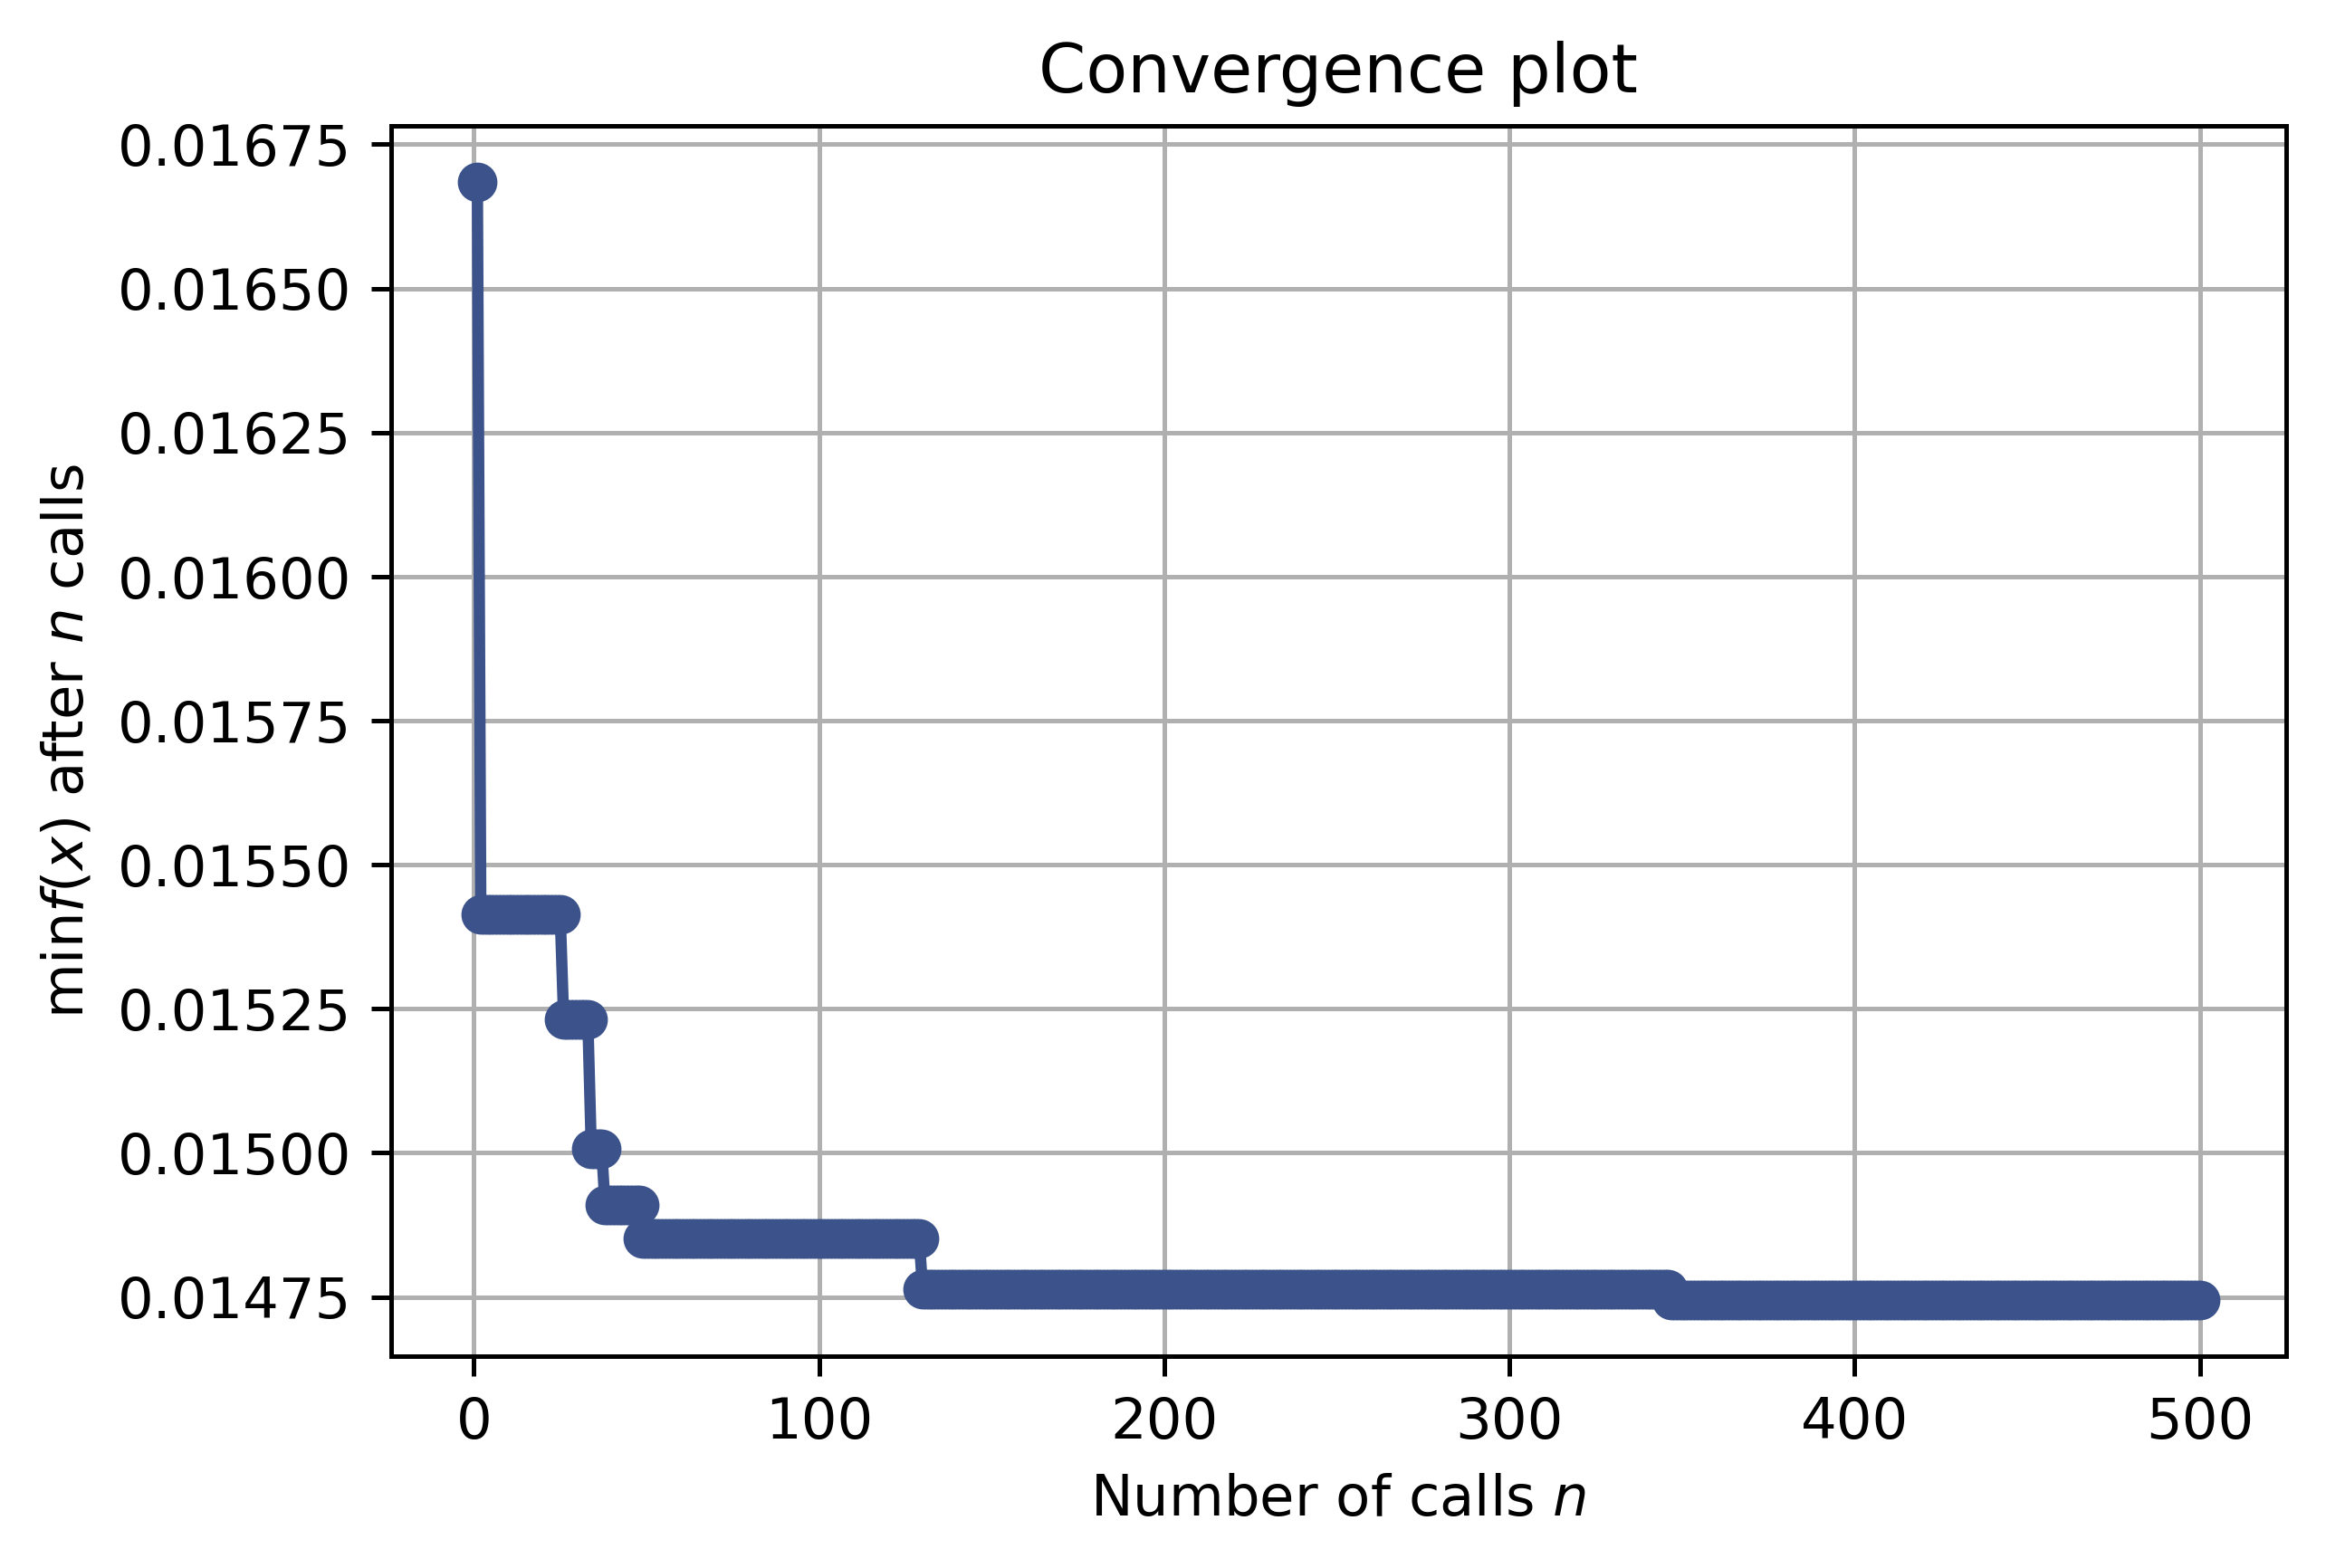

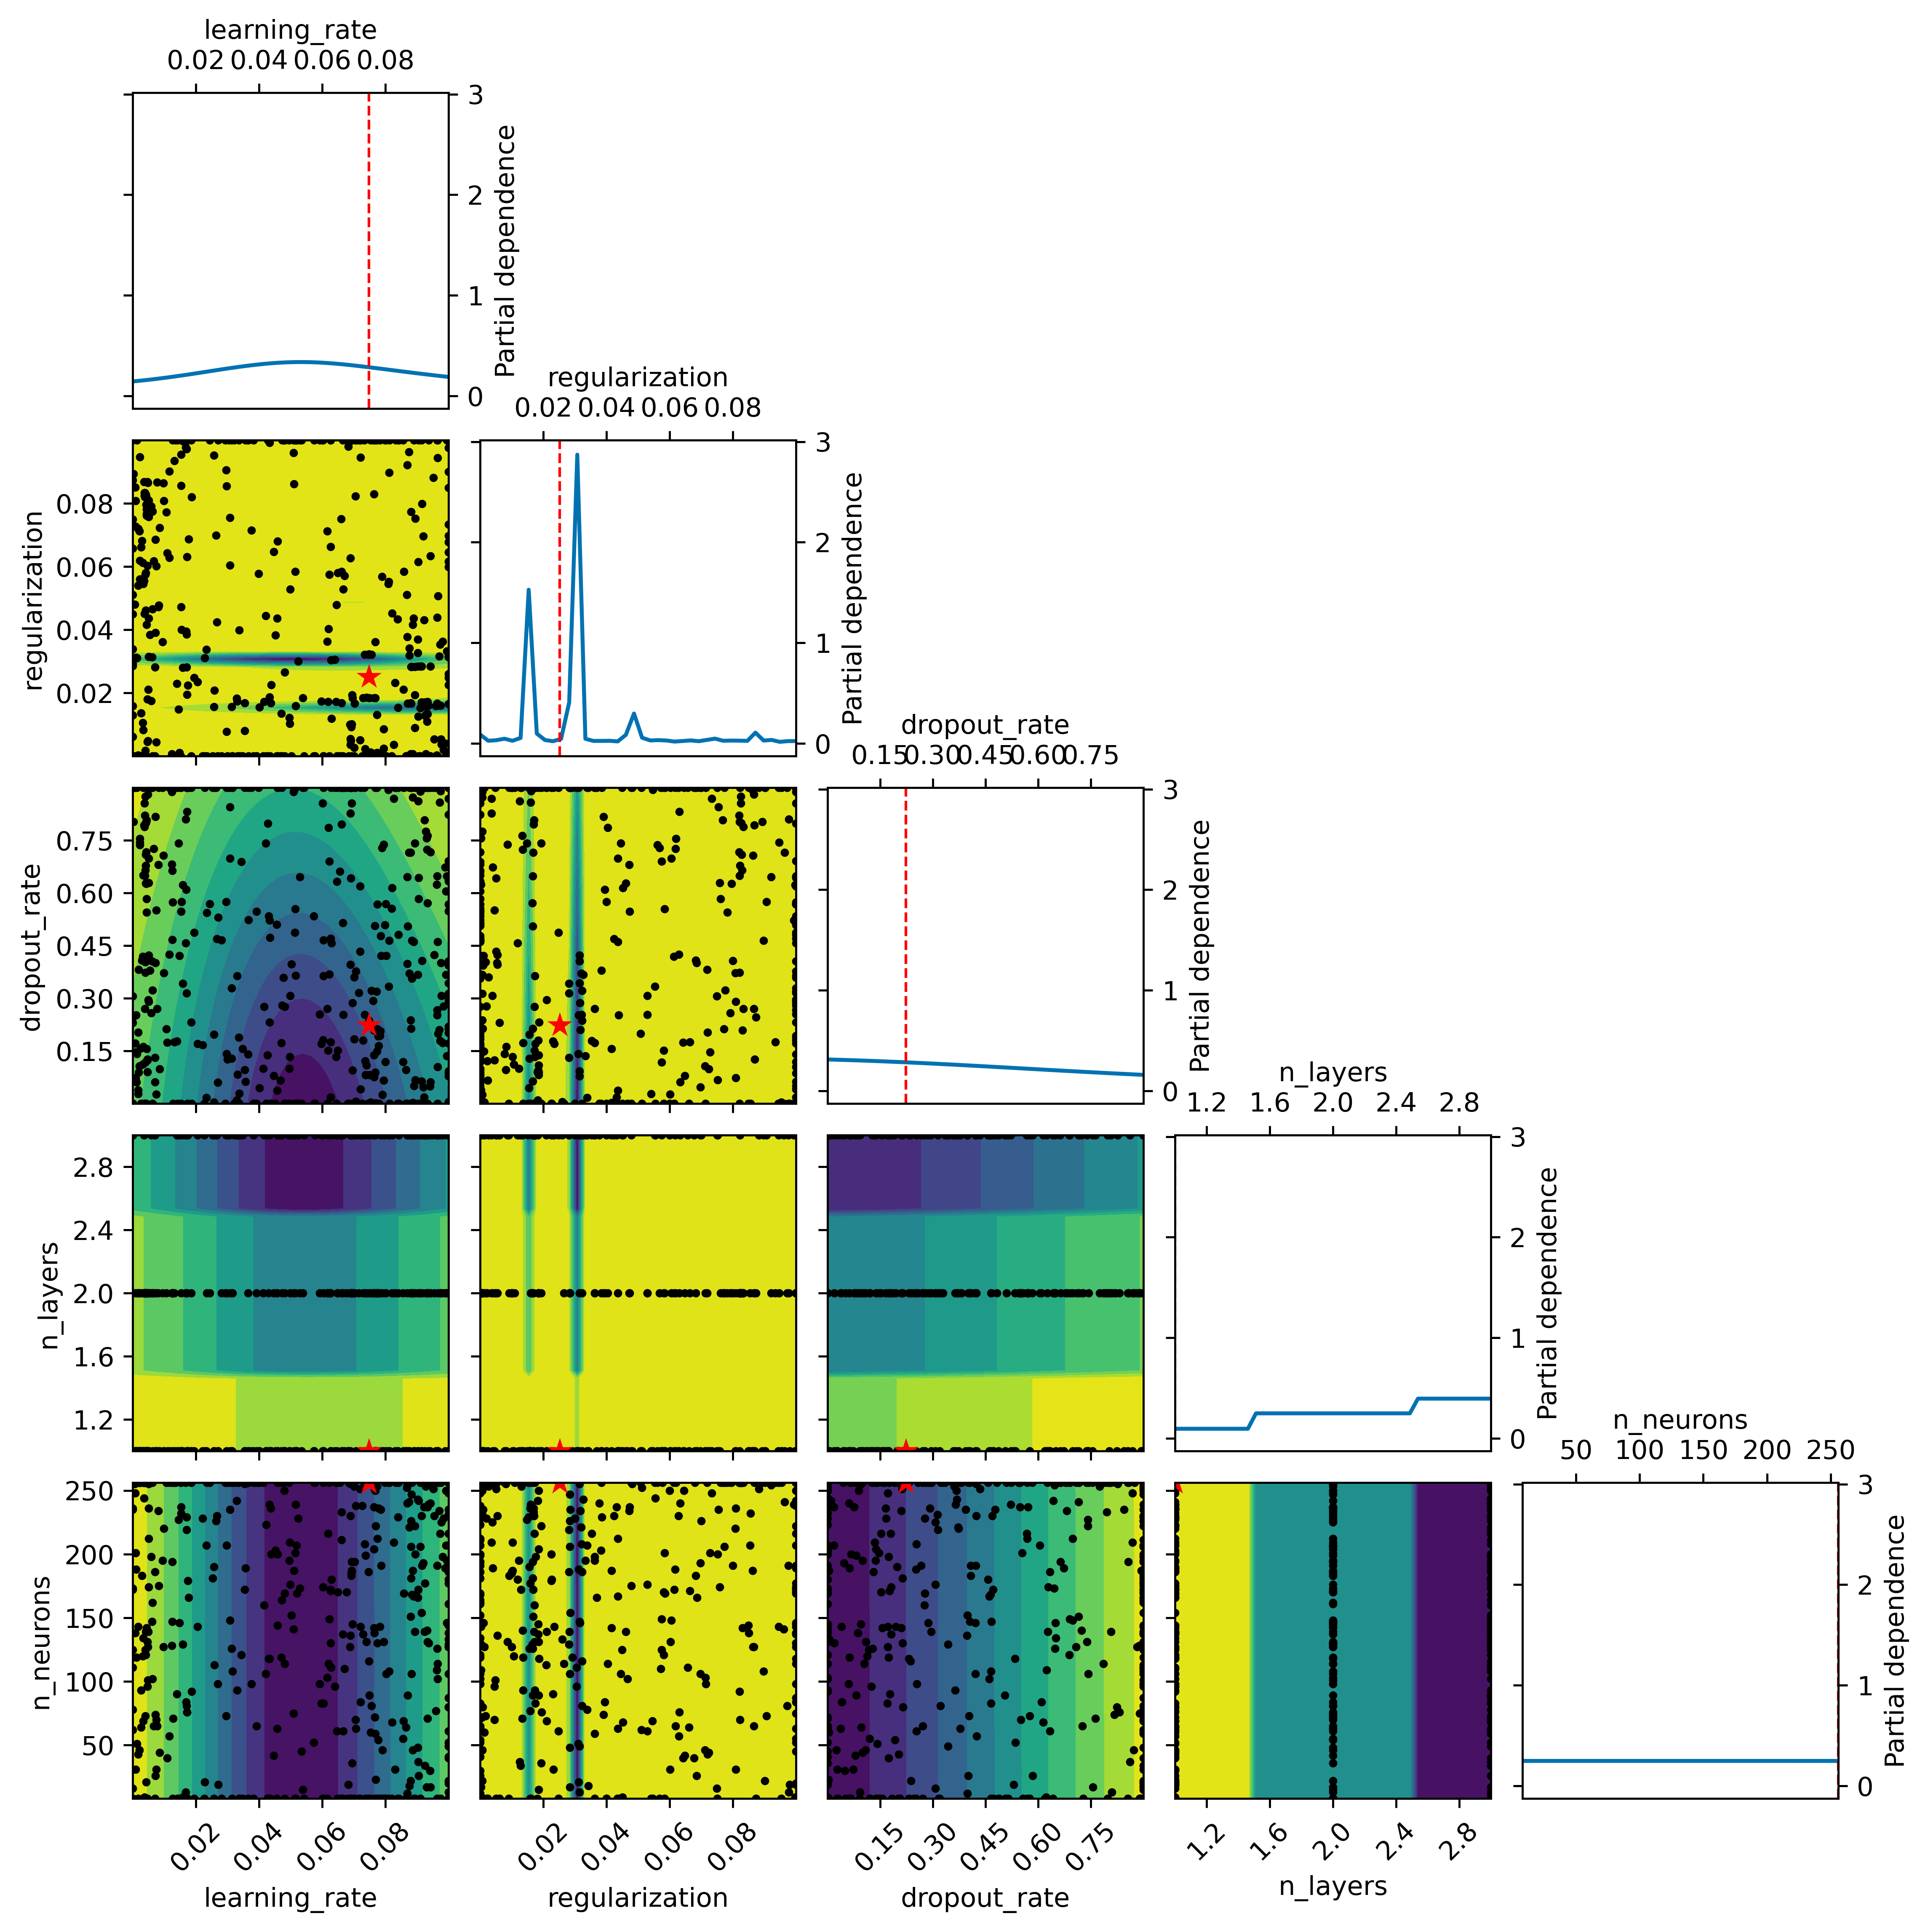

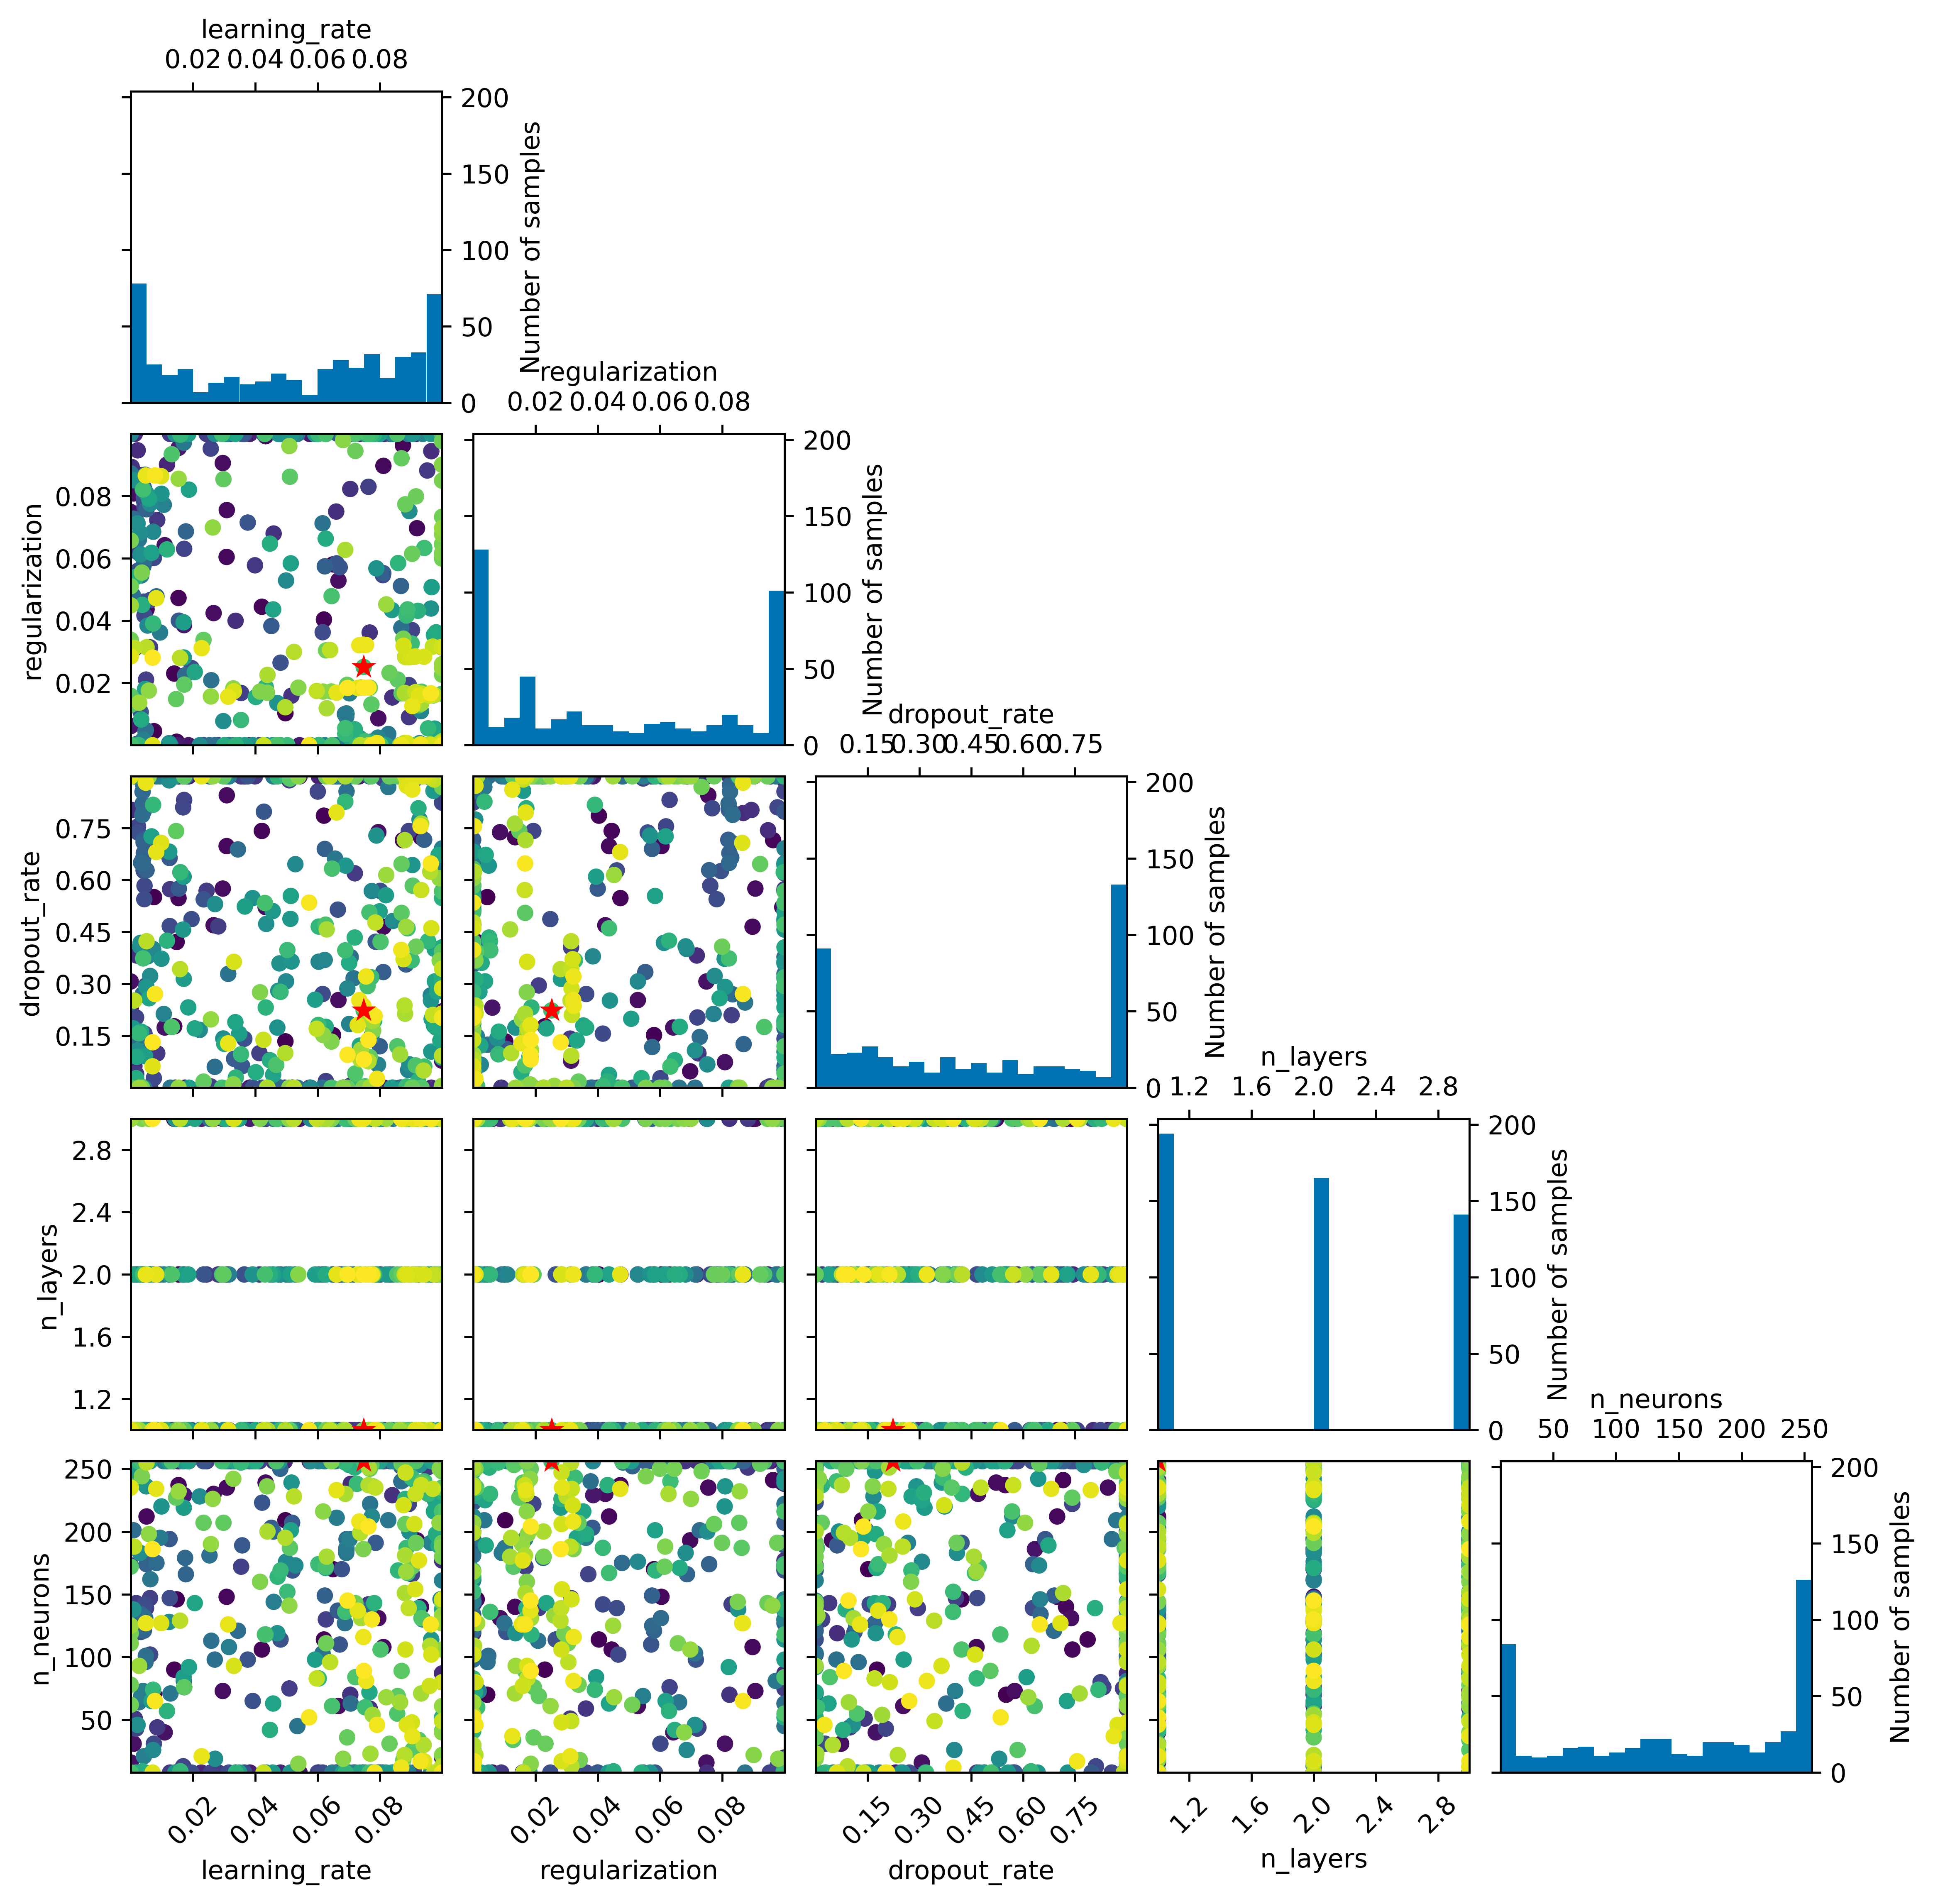

In [19]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
space = []
# space.append(Categorical(['relu', 'leakyrelu', 'elu'], name='activation'))
space.append(Real(1e-5, 1e-1, name='learning_rate'))
space.append(Real(1e-10, 1e-1, name='regularization'))
space.append(Real(0.0, 0.9, name='dropout_rate'))
# space.append(Integer(int(16), int(312), name='batch_size', dtype=int))
# space.append(Categorical(['relu', 'leakyrelu', 'prelu', 'elu', 'selu'], name='activation'))
space.append(Integer(int(1), int(3), name='n_layers', dtype=int))
space.append(Integer(int(8), int(256), name='n_neurons', dtype=int))

# # Set default hyperparameters
# default_params = [1e-3,
#                   1e-5,
#                   0.25,
#                   2,
#                   128]

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, dropout_rate, n_layers, n_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    # if activation == 'relu':
    #     activation = nn.ReLU()
    # elif activation == 'leakyrelu':
    #     activation = nn.LeakyReLU()
    # elif activation == 'elu':
    #     activation = nn.ELU()
    # elif activation == 'selu':
    #     activation = nn.SELU()
    # elif activation == 'prelu':
    #     activation = nn.PReLU()

    # print(f'Learning Rate: {learning_rate:.0e}, Regularization: {regularization:.0e}, ', end='')
    # print(f'Dropout: {dropout:.2f}')  #, Batch Size: {batch_size}')

    model = NeuralNet(activation=nn.ELU(), dropout_rate=dropout_rate, n_neurons=n_neurons, n_layers=n_layers)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                                weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(x_train=x_train, y_train=y_train,
                                     model=model, optimizer=optimizer,
                                     batch_size=312, patience=100)
    # print(f'Avg. best validation loss: {avg_best_loss}')

    return avg_best_loss

n_calls = 500
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(func=fitness,
                        dimensions=space,
                        n_calls=n_calls,
                        n_initial_points=20,
                        random_state=SEED,
                        verbose=True, callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x